# **San Francisco Crime Analysis & Prediction**

**Felix Riedel, Jens Kröning**




**HTW Berlin**

#  I. Gliederung

<!-- 
    Frame the problem and look at the big picture.
    Get the data.
    Explore the data to gain insights.
    Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
    Explore many different models and short-list the best ones.
    Fine-tune your models and combine them into a great solution.
    Present your solution.
    Launch, monitor, and maintain your system.
-->

1. [Einleitung](#1-einleitung)
2. [Aufgabenstellung](#2-problemstellung)
3. [Import](#3-import)
4. [Datenbereinigung](#4-datenbereinigung)
5. [Exploration](#5-exploration)
6. [Vorbereitung](#6-vorbereitung)
7. [Modellierung](#7-modellierung)
8. [Fazit](#8-fazit)



# 1. Einleitung 

San Francisco war berüchtigt dafür, einige der weltweit bekanntesten Verbrecher auf der unentrinnbaren Insel Alcatraz unterzubringen. Heute ist die Stadt eher für ihre Technologieszene als für ihre kriminelle Vergangenheit bekannt. Ziel dieser Analyse ist eine Klassifizierung und Vorhersage von ausgewählten Verbrechenskategorien, basierend auf Zeit, Ort und weiteren Features. Als Grundlage hierfür dienen Kriminalberichte der letzten 14 Jahre, welche Daten aus allen Vierteln San Franciscos enthalten. 


# 2. Problemstellung

<!-- Frame the problem and look at the big picture. -->

Für die weitere Betrachtung werden im Folgenden die ersten Schritte unternommen, um eine Kategorie eines Verbrechens in San Francisco vorherzusagen. Um den Umfang der Daten zu reduzieren, beschränkt sich diese Analyse ausschließlich auf die nachstehenden Kategorien:


 *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* 


Zur Vorhersage soll **eine** dieser Methoden verwendet werden: 

*Regression*, *Klassifikation* oder *Clustering*


Im Verlauf der Analyse wird die Entscheidung zur Vorhersage einer Kategorie eines Verbrechens auf die Klassifikation fallen.



# 3. Import

Im ersten Abschnitt dieser Analyse werden verschiedene Python-Bibliotheken importiert, um Datenanalyse, Visualisierung und maschinelles Lernen durchzuführen. Außerdem werden die entsprechenden Daten importiert.

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
from joblib import parallel_backend
from meteostat import Point, Hourly
from scipy import stats
from shapely.geometry import Point, Polygon, MultiPolygon
from sklearn import tree
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split, cross_validate
from sklearn.svm import LinearSVC
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import holidays

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

data\grid_search_svm.csv
data\grid_search_tree.csv
data\random_search_tree.csv
data\SF Find Neighborhoods.geojson
data\train.csv


# 4. Datenbereinigung 

Im nächsten Schritt folgt die Datenbereinigung, damit die Qualität der Daten überprüft werden kann. Außerdem werden Maßnahmen zur Bereinigung des Datensatzes durchgeführt.

In [131]:
crime = pd.read_csv("data/train.csv")
crime["CrimeId"] = crime.index
crime.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4


Zunächst werden die ersten fünf Zeilen aus dem Datensatz ausgegeben, um ein erstes Gefühl für die Daten und Kriminalitätsinformationen zu bekommen.

In [132]:
crime['Dates'] = pd.to_datetime(crime['Dates'])

print('First date: ', str(crime['Dates'].min()))
print('Last date: ', str(crime['Dates'].max()))
print('crime data shape: ', crime.shape)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
crime data shape:  (878049, 10)


## Selektion

Wie in der Problemstellung beschrieben, werden die Daten so gefiltert, dass nur *Larceny/Theft*, *Assault*, *Drug/Narcotic*, *Vehicle Theft* und *Burglary* als Kategorien vertreten sind.

In [133]:
crime["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [134]:
categories = [i.upper() for i in ["Larceny/Theft", "Assault", "Drug/Narcotic", "Vehicle Theft", "Burglary"]]

crime = crime.loc[crime["Category"].isin(categories)]

crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7


## Duplikate

Im nächsten Schritt werden die Duplikate im Datensatz untersucht:

In [135]:
crime.duplicated().sum()

0

In [136]:
crime.drop_duplicates(inplace=True)

## Datentypen

In [137]:
crime.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
CrimeId                int64
dtype: object

Ein Blick auf die Datentypen zeigt, dass sie bereits in einem gängigen Format vorliegen.
Lediglich die 'Dates' Spalte wird weiter unterteilt für spätere Analysen.

In [138]:
crime["Dates"] = pd.to_datetime(crime["Dates"])
crime["YearMonth"] = crime['Dates'].dt.strftime('%Y-%m')
crime["YearMonthDay"] = crime['Dates'].dt.strftime('%Y-%m-%d')
crime["MonthDay"] = crime['Dates'].dt.strftime('%m-%d')
crime["Year"] = crime['Dates'].dt.strftime('%Y')
crime["Month"] = crime['Dates'].dt.strftime('%m')
crime["Day"] = crime['Dates'].dt.strftime('%d')
crime["TimeOfDay"] = crime['Dates'].dt.strftime('%H')

## Falsche Werte

Im nächsten Schritt wird betrachtet, ob die Koordinaten falsche Werte enthalten könnten.

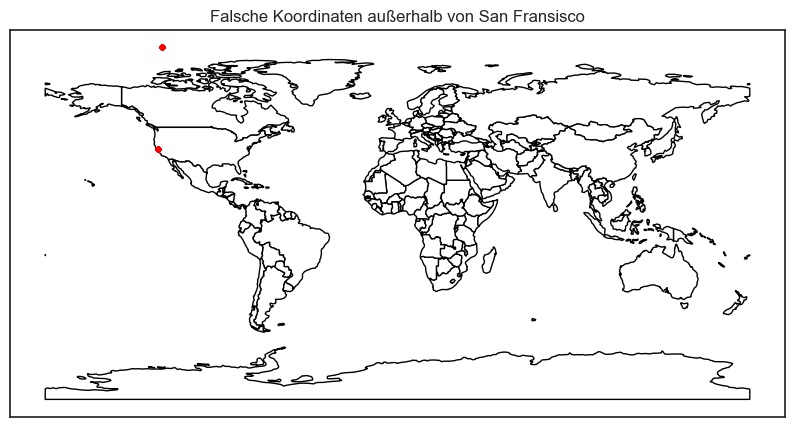

In [139]:


def create_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs='epsg:4326')
    return gdf


crime_gdf = create_gdf(crime)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 10))

world.plot(ax=ax, color='white', edgecolor='black')
crime_gdf.plot(ax=ax, color='red', markersize=10)  # Adjust markersize as needed

ax.set_aspect('equal')

#sns.despine(ax=ax, left=True, right=True, top=True, bottom=True)

ax.set_xticks([])  # Use set_xticks to hide x-axis ticks
ax.set_yticks([])  # Use set_yticks to hide y-axis ticks

plt.title("Falsche Koordinaten außerhalb von San Fransisco")
plt.show()


Ein Blick auf die Karte genügt, um zu sehen, dass sich einige Punkte außerhalb der USA und außerhalb von San Fransisco befinden. Diese Punkte werden konkret lokalisiert und im nächsten Schritt ausgegeben. 

In [140]:
print(crime_gdf.loc[crime_gdf.Y > 50].count()[0])
crime_gdf.loc[crime_gdf.Y > 50].sample(5)

29


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId,YearMonth,YearMonthDay,MonthDay,Year,Month,Day,TimeOfDay,geometry
759397,2004-08-03 19:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,LARKIN ST / AUSTIN ST,-120.5,90.0,759397,2004-08,2004-08-03,08-03,2004,08,03,19,POINT (-120.50000 90.00000)
823378,2003-09-21 13:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,BAYVIEW,NONE,GILMAN AV / FITCH ST,-120.5,90.0,823378,2003-09,2003-09-21,09-21,2003,09,21,13,POINT (-120.50000 90.00000)
687519,2005-08-13 17:00:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Saturday,TENDERLOIN,NONE,JENNINGS CT / INGALLS ST,-120.5,90.0,687519,2005-08,2005-08-13,08-13,2005,08,13,17,POINT (-120.50000 90.00000)
677260,2005-10-06 17:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Thursday,RICHMOND,NONE,AVENUE OF THE PALMS / EUCLID AV,-120.5,90.0,677260,2005-10,2005-10-06,10-06,2005,10,06,17,POINT (-120.50000 90.00000)
678326,2005-10-04 09:00:00,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Tuesday,INGLESIDE,NONE,PERSIA AV / LAGRANDE AV,-120.5,90.0,678326,2005-10,2005-10-04,10-04,2005,10,04,09,POINT (-120.50000 90.00000)


Zusammengefasst gibt der Code also die Anzahl der Datensätze mit einer Y-Koordinate größer als 50 aus und zeigt dann fünf zufällige Datensätze mit dieser Bedingung an. Dies könnte darauf hindeuten, dass es im GeoDataFrame einige Datensätze mit ungewöhnlichen oder fehlerhaften geografischen Koordinaten gibt. Damit diese auffälligen Daten nicht aus der Analyse ausgeschlossen werden, können die Mittelwerte der vorhandenen Koordinaten der jeweiligen Polizeidistrikte genutzt werden.

In [141]:
crime.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in crime['PdDistrict'].unique():
    crime.loc[crime['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        crime.loc[crime['PdDistrict'] == district, ['X', 'Y']])

crime_gdf = create_gdf(crime)

Es wird folglich für jedes einzigartige Polizeidistrikt ('PdDistrict') im DataFrame crime der Imputer verwendet, um fehlende Werte in den Spalten 'X' und 'Y' durch den Mittelwert der vorhandenen Werte im jeweiligen Distrikt zu ersetzen.

## Fehlende Werte

In [142]:
crime.isnull().sum()

Dates           0
Category        0
Descript        0
DayOfWeek       0
PdDistrict      0
Resolution      0
Address         0
X               0
Y               0
CrimeId         0
YearMonth       0
YearMonthDay    0
MonthDay        0
Year            0
Month           0
Day             0
TimeOfDay       0
dtype: int64

In [143]:
if sum(crime.isnull().any()*1):
    print("Es gibt fehlende Daten.")
else:
    print("Es gibt keine fehlenden Daten")

Es gibt keine fehlenden Daten


Nachdem die Koordinaten bereinigt wurden, werden weitere fehlende Werte berücksichtigt. Dafür wird die obenstehende Funktion verwendet, um die Anzahl der fehlenden Werte in jedem Attribut (Spalte) des DataFrames zu zählen.

Wie aus der Tabelle abgelesen werden kann, gibt es für alle Kategorien keine fehlenden Werte. 




# 5. Exploration

Nachdem die Datenbereinigung abgeschlossen wurde, wird nun der Fokus auf die Exploration der Daten gelegt. Hierbei handelt es sich um einen Prozess, bei dem der Datensatz analysiert wird, um ein besseres Verständnis für die enthaltenen Variablen zu entwickeln. Ziel ist es, Muster, Trends oder ungewöhnliche Beobachtungen zu identifizieren. Dieser Prozess hilft bei der Vorbereitung der Daten für die weitere Analyse und Modellbildung.

## Deskriptive Statistik

### Verbrechen je Bezirk

In [144]:
data_cat = crime.groupby('Category').count().iloc[:, 0]. sort_values(ascending=False)
data = data_cat.reindex(np.append(np.delete(data_cat.index, 1), 'OTHER OFFENSES'))



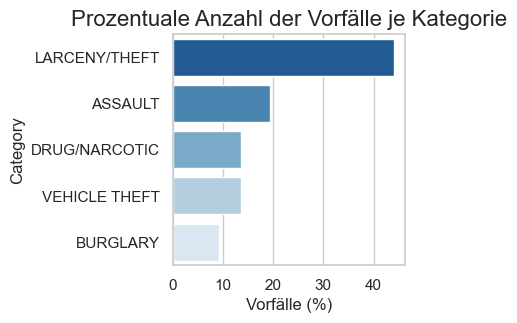

In [145]:
plt.figure(figsize=(3, 3))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x = (data_cat.values / data_cat.values.sum()) * 100,
        y = data_cat.index,
        orient='h',
        palette="Blues_r")

plt.title('Prozentuale Anzahl der Vorfälle je Kategorie', fontdict={'fontsize': 16})
plt.xlabel('Vorfälle (%)')

plt.show()

Für einen ersten Überblick werden Einzelfälle pro Kategorie in Prozent aufgeschlüsselt. Es ist deutlich zu erkennen, dass 'Larceny/Theft' nahezu 50 Prozent der Fälle ausmacht. Dahingegen werden nur knapp unter 10 Prozent der Fälle als 'Burglary' klassifiziert.

In [146]:
data_cat.describe()

count         5.000000
mean      79256.600000
std       55335.524271
min       36755.000000
25%       53781.000000
50%       53971.000000
75%       76876.000000
max      174900.000000
Name: Dates, dtype: float64

Für die weitere Einordnung wird die Funktion describe() genutzt. Wie bereits in der Selektion deutlich wurde, wird in der Analyse nur mit den fünf ausgewählten Kategorien gearbeitet. Außerdem können einige grundlegende statistische Maße abgelesen werden.

### Histogramme

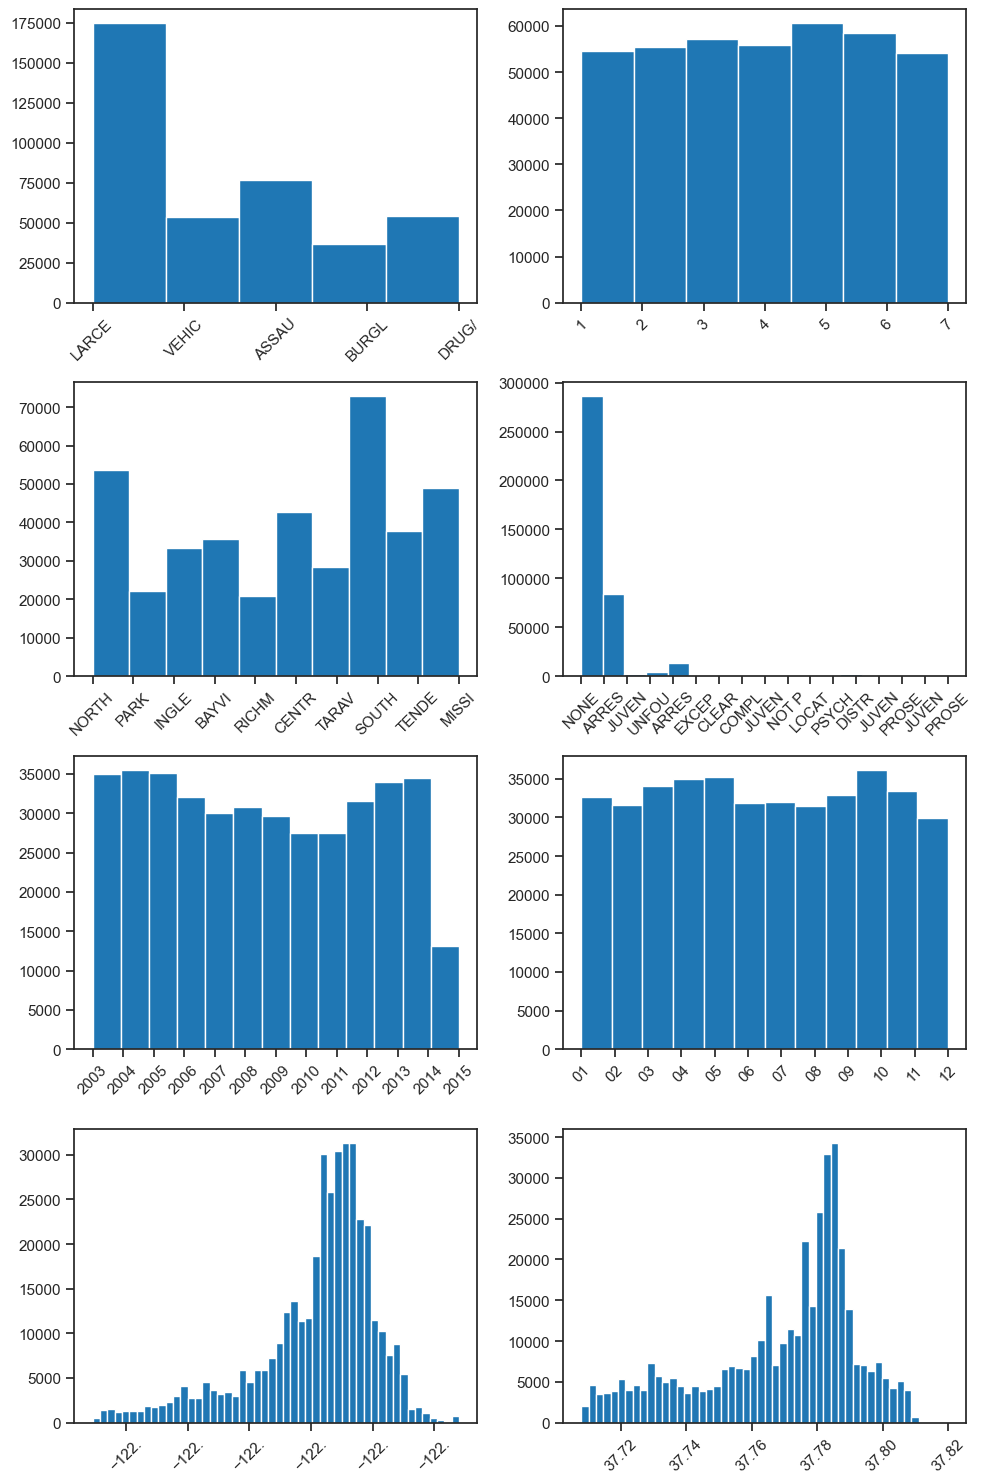

In [151]:


def truncate_label(label, length=5):
    return label[:length]

colors = sns.color_palette(None, 3)
columns = ["DayOfWeek", "PdDistrict", "Resolution"]


fig, axes = plt.subplots(4, 2, figsize = (10, 15), tight_layout=True)

axes[0, 0].hist(crime["Category"], bins=5, align="mid")

#Tag der Woche als Zahl für Sortierung der Balken
axes[0, 1].hist(crime['Dates'].dt.weekday + 1, bins=7, align="mid")

axes[1, 0].hist(crime["PdDistrict"], bins=len(crime["PdDistrict"].unique()))
axes[1, 1].hist(crime["Resolution"], bins=len(crime["Resolution"].unique()))
axes[2, 0].hist(crime["Year"].sort_values(), bins=13)
axes[2, 1].hist(crime["Month"].sort_values(), bins=12)
axes[3, 0].hist(crime["X"], bins=50)
axes[3, 1].hist(crime["Y"], bins=50)

# Rotate x-axis tick labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_ticks_position('bottom')  # Place ticks at the bottom for better visibility
    ax.set_xticklabels([truncate_label(label.get_text()) for label in ax.get_xticklabels()])

plt.tight_layout()
plt.show()

Hier werden Histogramme für verschiedene Merkmale des Kriminalitätsdatensatzes erstellt, einschließlich der Kategorie der Straftaten, dem Wochentag, dem Polizeibezirk, der Auflösung, dem Jahr, dem Monat sowie den geografischen Koordinaten X und Y. 

### Zeitliche Regression

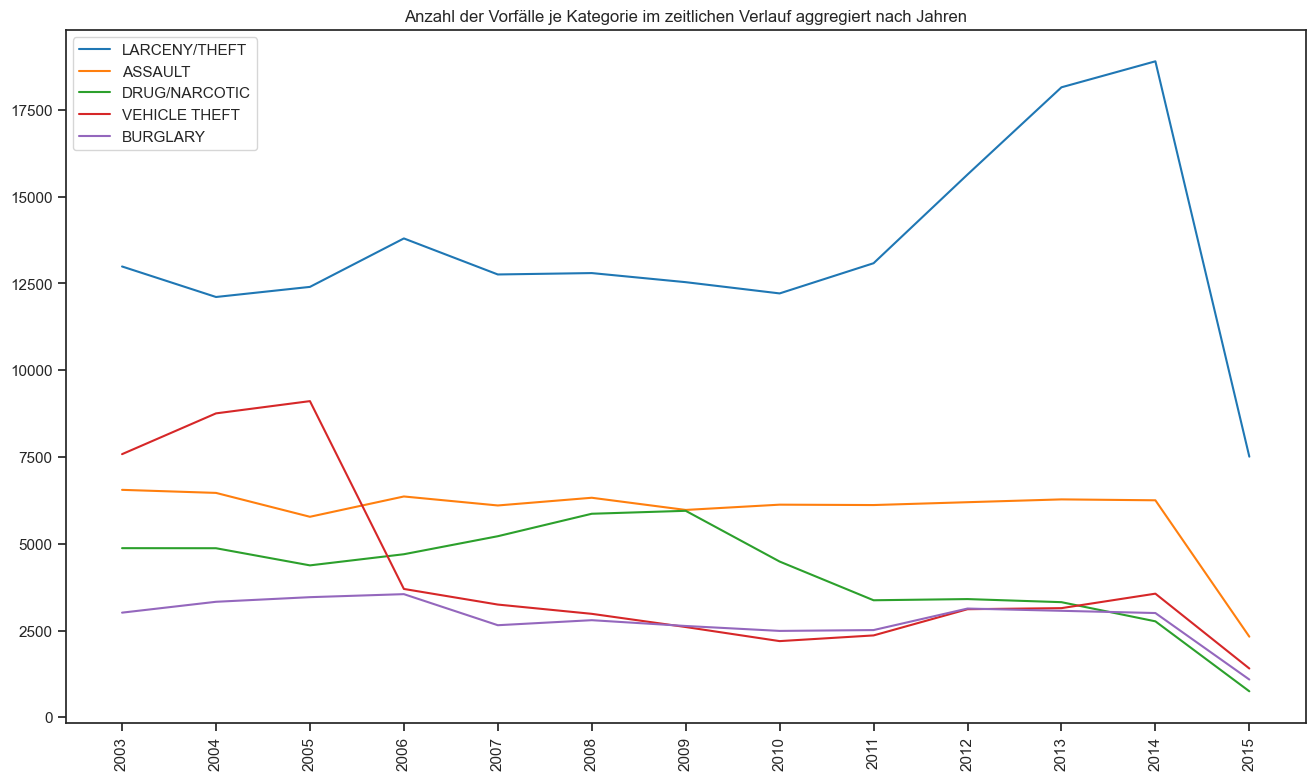

In [148]:
sns.set_style("ticks")
sns.set_context('notebook', font_scale = 1)

crime_year_cat = crime.groupby(by=["Year", "Category"], as_index=False).count()
data = crime_year_cat.pivot_table(index="Year", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix, rotation=90, ha="center")
plt.title("Anzahl der Vorfälle je Kategorie im zeitlichen Verlauf aggregiert nach Jahren")
plt.show()


Es folgt eine Visualisierung der zeitlichen Regression und Entwicklung der Straftaten in verschiedenen Kategorien über die Jahre, gruppiert nach 'Year', wodurch Trends und Muster im zeitlichen Verlauf sichtbar werden. Besonders auffällig ist der Abfall von 'Larceny/Theft' nach dem Jahr 2014.

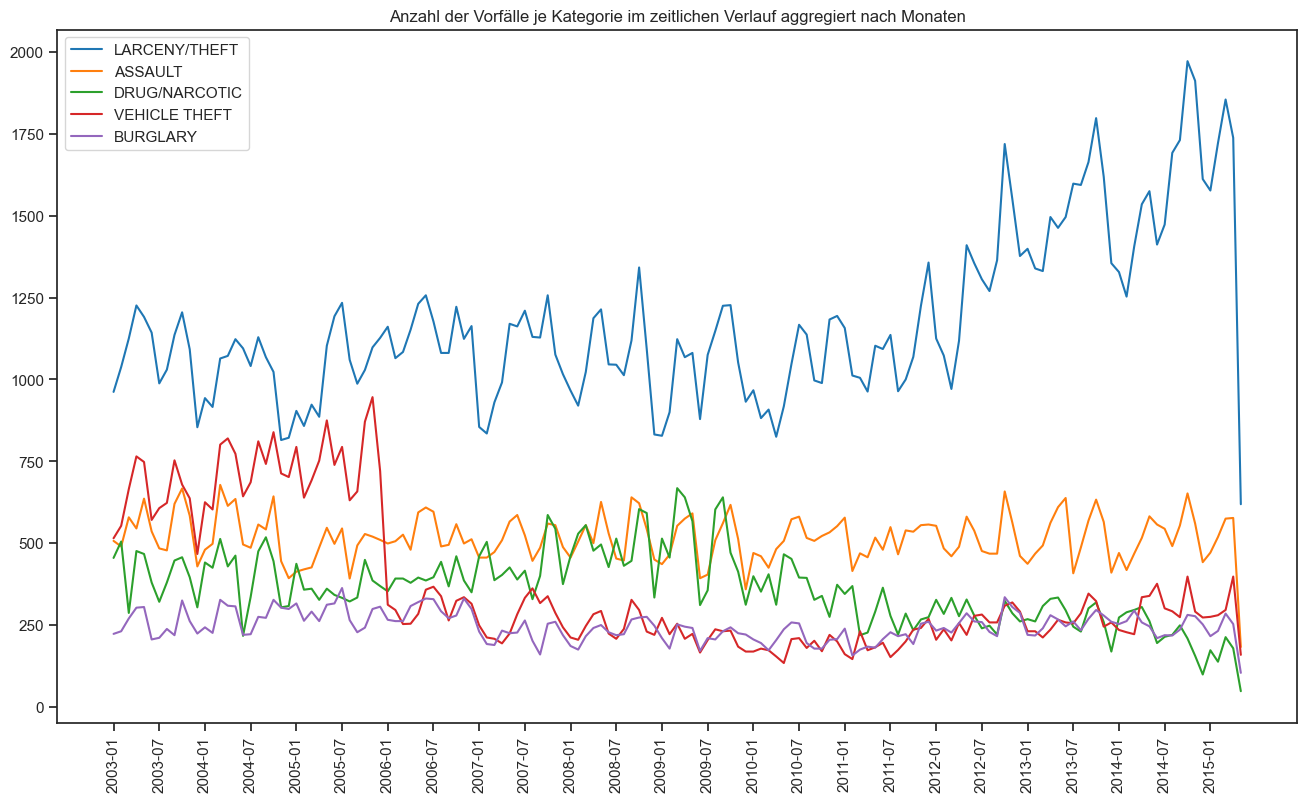

In [149]:
crime_yearmonth_cat = crime.groupby(by=["YearMonth", "Category"], as_index=False).count()
data = crime_yearmonth_cat.pivot_table(index="YearMonth", columns="Category", values="Descript")

fig = plt.figure(figsize=(16,9))

for category in categories:
    plt.plot(data[category], label=category)

plt.legend(loc="upper left")
tix = plt.xticks()[0]
plt.xticks(tix[::6], rotation=90, ha="center")
plt.title("Anzahl der Vorfälle je Kategorie im zeitlichen Verlauf aggregiert nach Monaten")
plt.show()

Diese Visualisierung zeigt ebenfalls die zeitliche Entwicklung der Straftaten nach den jeweiligen Kategorien. In diesem Fall wird jedoch eine Gruppierung nach 'YearMonth' vorgenommen, damit eine feinere zeitliche Auflösung ersichtlich wird. 

### Kartogramme

In [150]:

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(crime.X, crime.Y)]
crime_gdf = GeoDataFrame(crime, crs="EPSG:4326", geometry=geometry)


point = crime_gdf
poly  = sf_df

pointInPolys = sjoin(point, poly, how='left')
pointInPolys.drop_duplicates(subset=['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
                                     'Resolution', 'Address', 'X', 'Y', 'YearMonth', 'Year', 'Month', 'Day',
                                     'TimeOfDay'], inplace=True)

pointInPolys = pointInPolys.rename(columns ={"name" : "crdistrict"})

crime = crime.join(pointInPolys[["CrimeId", "crdistrict"]], on="CrimeId", lsuffix="_")

grouped = pointInPolys.groupby('index_right').count()


Hier wird ein GeoDataFrame (sf_df) aus einer GeoJSON-Datei eingelesen, die die Grenzen der Stadtviertel von San Francisco enthält. Die to_crs-Methode wird verwendet, um die Koordinatenreferenz des GeoDataFrames auf das Standardformat (EPSG:4326) zu ändern, das Längen- und Breitengrade verwendet. 
Vgl. City and County of San Francisco. (2016). SF Find Neighborhoods. [Dataset]. Socrata. https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

Insgesamt ermöglicht dieses Vorgehen die Zuordnung von Kriminalitätsdaten zu den entsprechenden Stadtvierteln von San Francisco und die Berechnung der Anzahl der Vorkommen in jedem Viertel. Dies ist nützlich, um räumliche Muster und Hotspots von Kriminalität zu identifizieren.

In [153]:
heat_districts = pointInPolys.groupby(['index_right', 'crdistrict'])["Category"].count()
heat_districts

index_right  crdistrict            
0.0          Seacliff                   239
1.0          Lake Street                450
2.0          Presidio National Park      36
3.0          Presidio Terrace           465
4.0          Inner Richmond            4975
                                       ... 
112.0        Corona Heights             579
113.0        Ashbury Heights            591
114.0        Eureka Valley             1664
115.0        St. Francis Wood           226
116.0        Sherwood Forest            191
Name: Category, Length: 117, dtype: int64

In heat_districts werden dafür Indexwerte für die einzelnen Stadtviertel erstellt. Die Werte repräsentieren dabei die Anzahl der Kriminalitätsvorfälle in jedem Stadtviertel.

In [155]:

geom = sf_df.pop('geometry')
sf_df = sf_df.join(geom, how='inner')
sf_df["polygons"] = ""
for i,row in sf_df.iterrows():
    geometry = row["geometry"]
    if geometry.geom_type == 'MultiPolygon':
        polygons = []
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            interior_coords = [list(interior.coords) for interior in polygon.interiors]
            polygons.append(Polygon(exterior_coords, interior_coords))
    else:
        polygons = [Polygon(list(geometry.exterior.coords))]
    sf_df.at[i, "polygons"] = polygons

sf_df["polygons"] = sf_df["polygons"].explode()

sf_df["index_right"] = sf_df.index
sf_df["heat"] = sf_df.merge(heat_districts, on="index_right")["Category"]
sf_df["geometry"] = sf_df["polygons"]

gdf = gpd.GeoDataFrame(sf_df)




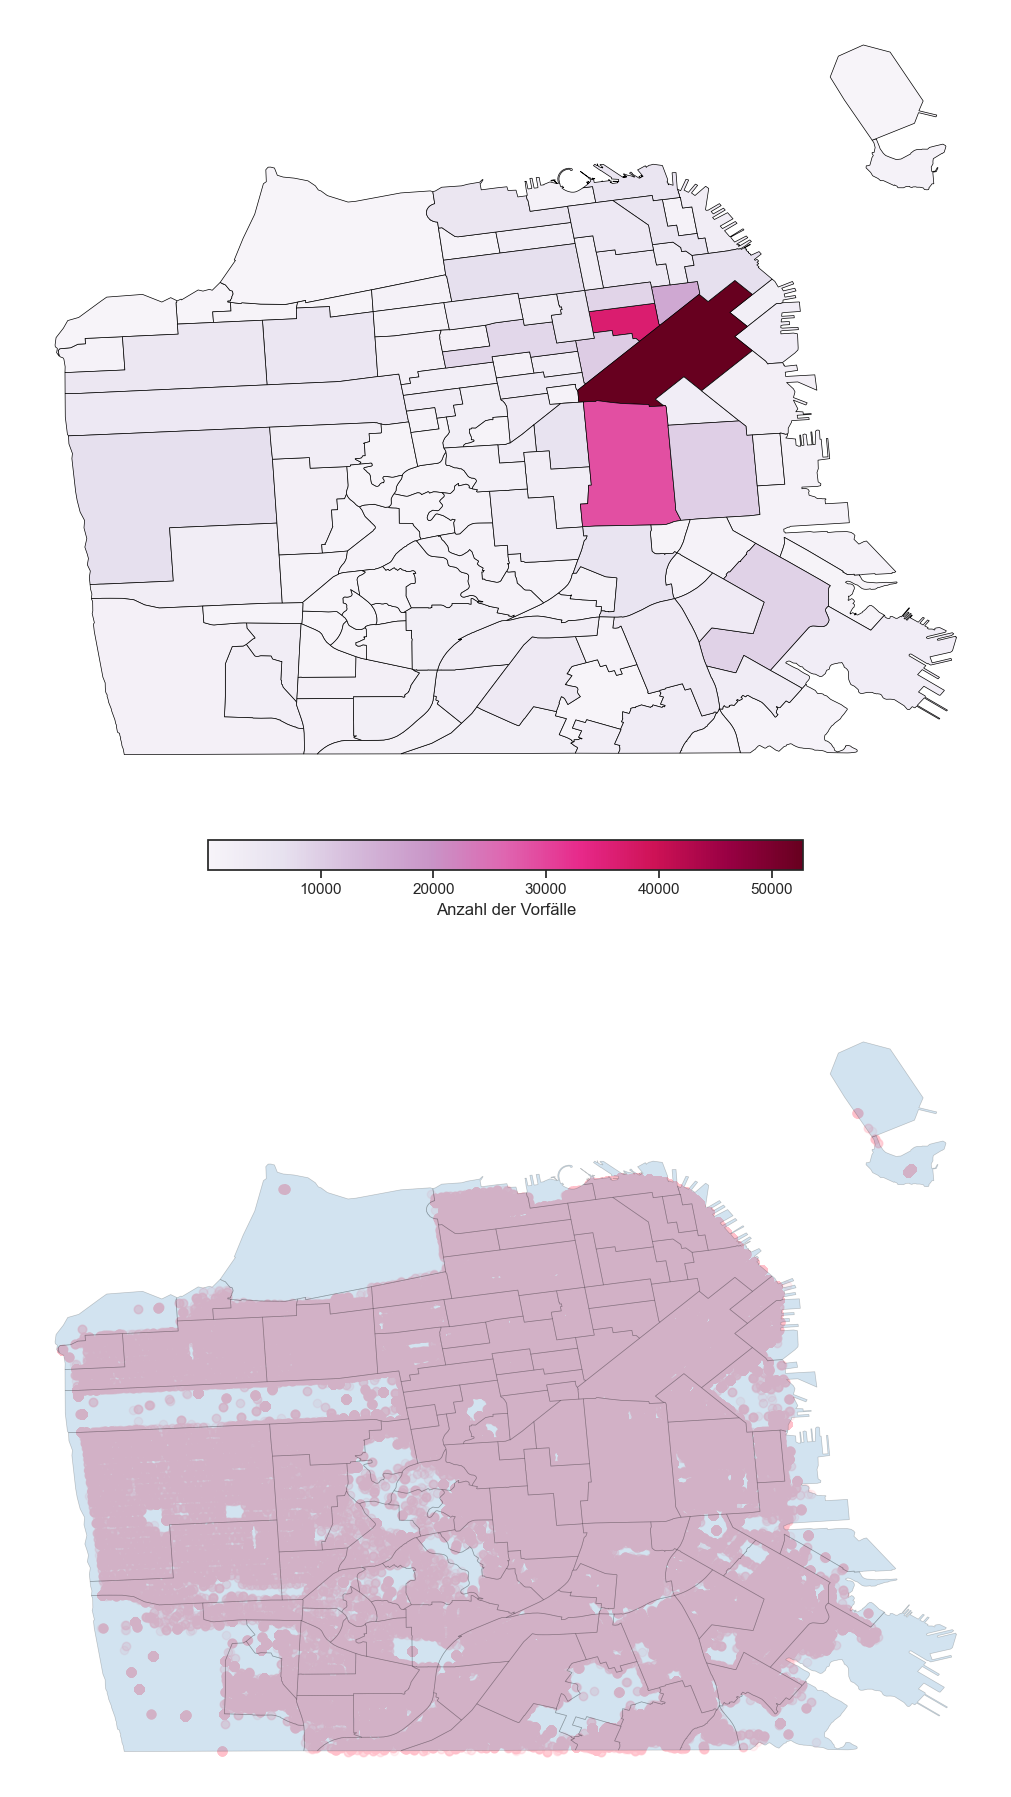

In [156]:
fig, ax = plt.subplots(2,1,figsize=(10, 20), layout='constrained')

gdf.plot(ax=ax[0], alpha=1, edgecolor='k', linewidth=0.5, column="heat", cmap="PuRd")
cbar = plt.colorbar(ax[0].get_children()[0], ax=ax[0], orientation="horizontal", shrink=0.6)
cbar.set_label("Anzahl der Vorfälle")

sf_df = gpd.read_file("data/SF Find Neighborhoods.geojson").to_crs({'init': 'epsg:4326'})
sf_df.plot(ax=ax[1], alpha=0.2, edgecolor='k', linewidth=0.5, zorder=2)
ax[1].scatter(data=crime.loc[crime["Y"]<80], x="X", y="Y",alpha=0.2, color="pink", zorder=1)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

sns.despine(ax=ax[0], left=True, right=True, top=True, bottom=True)
sns.despine(ax=ax[1], left=True, right=True, top=True, bottom=True)

ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])

ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])    
    
plt.show()



Insgesamt kann in der Heat-Map ein deutliches Muster erkannt werden. Die Kriminalfälle bündeln sich besonders in den Stadtvierteln im Nordosten von San Francisco. Im unteren Diagramm ist außerdem erkennbar, wie die Koordinaten den Bezirken zugeordnet wurden und wie dementsprechend das obere Diagramm zustande kam. 

## Feature Engineering

An dieser Stelle werden neue Spalten generiert, die den Datensatz bereichern und den Modellen helfen können.

### Feiertage

Zuerst werden die US-Feiertage importiert und dem Datensatz hinzugefügt.

In [157]:


usa_holidays = pd.Series(holidays.country_holidays('US',  years=range(crime["Dates"].dt.year.min(), crime["Dates"].dt.year.max())))

usa_holidays = pd.DataFrame(usa_holidays)
usa_holidays.columns = ["Holiday"]
usa_holidays["YearMonthDay"] = pd.to_datetime(usa_holidays.index)
usa_holidays.reset_index(drop=True)

crime["YearMonthDay"] = pd.to_datetime(crime["YearMonthDay"])
crime = crime.merge(usa_holidays, on="YearMonthDay", how="left")

crime["Holiday"].fillna("None", inplace=True)

In [165]:
crime[["Dates", "Holiday"]].sort_values(by="Holiday").head()

,Dates,Holiday
259447,2006-12-25 02:53:00,Christmas Day
168296,2009-12-25 20:00:00,Christmas Day
168297,2009-12-25 19:50:00,Christmas Day
168298,2009-12-25 19:30:00,Christmas Day
168299,2009-12-25 19:30:00,Christmas Day


In [166]:
df_district_holiday = pd.crosstab(crime['Category'], crime['Holiday'])
df_district_holiday = df_district_holiday.loc[:, df_district_holiday.columns != 'None']
df_district_holiday.head()

Holiday,Christmas Day,Christmas Day (Observed),Columbus Day,Independence Day,Independence Day (Observed),Labor Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Day (Observed),Thanksgiving,Veterans Day,Veterans Day (Observed),Washington's Birthday
Category,,,,,,,,,,,,,,
ASSAULT,201,86,185,42,44,388,179,378,198,37,172,191,52,335
BURGLARY,117,47,112,16,13,102,92,151,45,10,98,80,34,166
DRUG/NARCOTIC,65,32,166,11,13,272,202,271,54,13,86,176,43,315
LARCENY/THEFT,368,183,516,57,63,729,461,688,241,76,319,463,157,756
VEHICLE THEFT,153,90,148,17,42,218,133,217,43,14,111,159,32,250


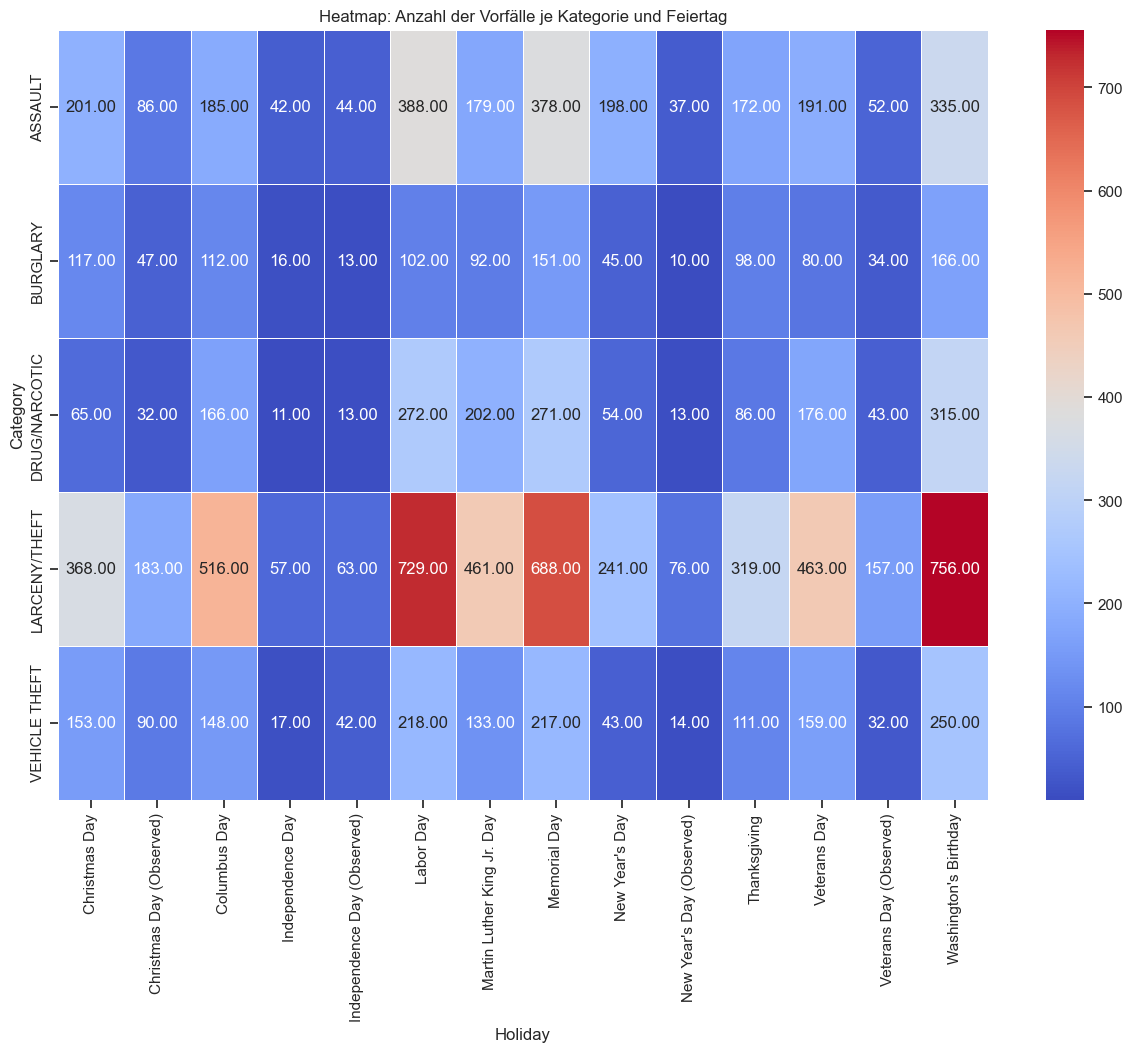

In [167]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_holiday, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap: Anzahl der Vorfälle je Kategorie und Feiertag')
plt.show()

In dieser Heat-Map werden die Feiertage den Kriminalkategorien entgegengestellt. Hier lässt sich ablesen, dass es die meisten Verbrechen am Labor Day und Washingtons Birthday gibt.

### Wetter

Die Daten werden um ein weiteres Feature erweitert. Hierfür werden die Wetterdaten für die entsprechende Region importiert.

In [29]:
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId_,YearMonth,YearMonthDay,MonthDay,Year,Month,Day,TimeOfDay,CrimeId,crdistrict,Holiday
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3,2015-05,2015-05-13,05-13,2015,05,13,23,3.0,Union Street,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4,2015-05,2015-05-13,05-13,2015,05,13,23,4.0,Buena Vista,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5,2015-05,2015-05-13,05-13,2015,05,13,23,5.0,Visitacion Valley,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6,2015-05,2015-05-13,05-13,2015,05,13,23,6.0,Excelsior,None
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7,2015-05,2015-05-13,05-13,2015,05,13,23,7.0,Hunters Point,None


In [168]:
crime["hours"] = pd.to_datetime(crime['Dates'].dt.strftime('%Y-%m-%d %H'))

In [174]:
from meteostat import Point, Hourly
import pandas as pd
import matplotlib.pyplot as plt

start_date = crime['Dates'].min()
end_date = crime['Dates'].max()

san_francisco = Point(37.7749, -122.4194, 10)

# Get hourly data for the specified date range
sf_weather = pd.DataFrame(Hourly(san_francisco, start_date, end_date).fetch())

sf_weather["hours"] = pd.to_datetime(sf_weather.index.strftime('%Y-%m-%d %H'))
crime = crime.merge(sf_weather, how="left", on="hours")

In [175]:
crime.describe()

,Dates,X,Y,CrimeId_,YearMonthDay,CrimeId,hours,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,396283,396283.000000,396283.000000,396283.000000,396283,395360.000000,396283,396277.000000,396277.000000,396277.000000,391924.00000,0.0,379557.000000,396277.000000,0.0,396277.000000,0.0,0.0
mean,2009-02-11 01:12:43.027432448,-122.422923,37.768880,445289.694544,2009-02-10 10:56:42.750054912,445432.070225,2009-02-11 00:54:13.420409088,14.355910,9.081409,72.990264,0.05265,NaN,229.170006,12.870807,NaN,1017.067608,NaN,NaN
min,2003-01-06 00:01:00,-122.513642,37.707920,3.000000,2003-01-06 00:00:00,3.000000,2003-01-06 00:00:00,-1.700000,-15.800000,8.000000,0.00000,NaN,10.000000,0.000000,NaN,995.700000,NaN,NaN
25%,2005-10-23 13:45:00,-122.433010,37.755504,216823.000000,2005-10-23 00:00:00,216969.750000,2005-10-23 13:30:00,11.700000,6.800000,63.000000,0.00000,NaN,180.000000,7.600000,NaN,1013.900000,NaN,NaN
50%,2008-12-26 12:00:00,-122.416642,37.776044,452744.000000,2008-12-26 00:00:00,453025.500000,2008-12-26 12:00:00,14.000000,9.900000,75.000000,0.00000,NaN,260.000000,11.200000,NaN,1016.700000,NaN,NaN
75%,2012-06-26 04:59:00,-122.407149,37.785103,673192.500000,2012-06-26 00:00:00,673364.750000,2012-06-26 04:30:00,17.200000,12.000000,86.000000,0.00000,NaN,290.000000,18.400000,NaN,1020.000000,NaN,NaN
max,2015-05-13 23:30:00,-122.364937,37.819975,878046.000000,2015-05-13 00:00:00,878046.000000,2015-05-13 23:00:00,36.700000,21.100000,100.000000,14.20000,NaN,360.000000,64.800000,NaN,1034.800000,NaN,NaN
std,NaN,0.025090,0.023801,257587.552855,NaN,257604.598322,NaN,4.610553,4.073596,16.489246,0.38607,NaN,86.088357,9.063533,NaN,4.664577,NaN,NaN


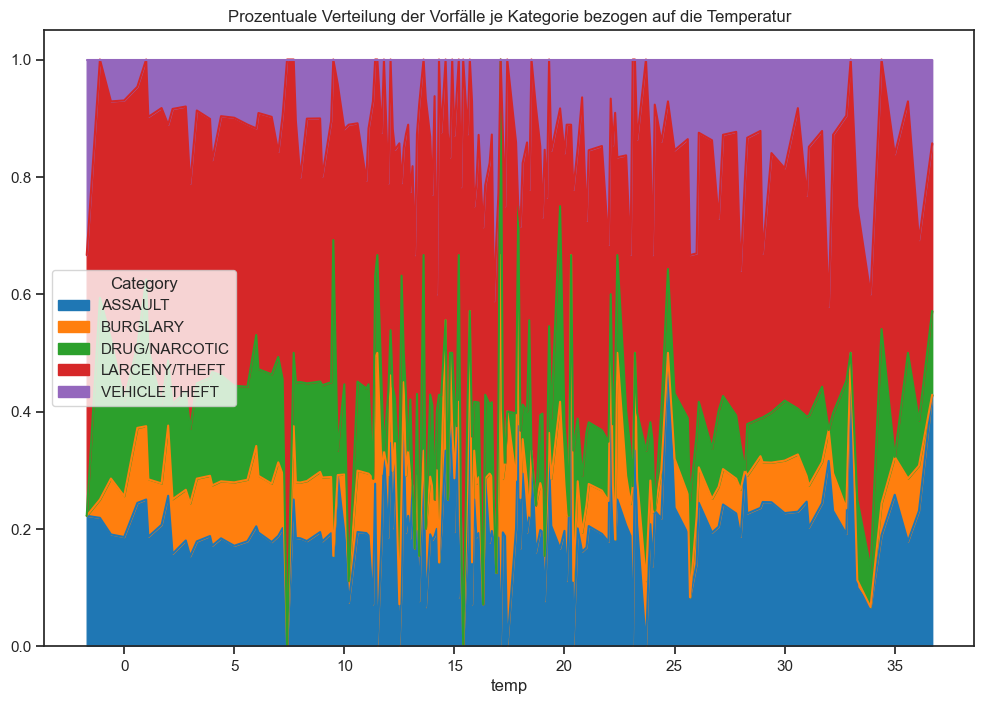

In [177]:
temp_cat_ct = pd.crosstab(crime["temp"], crime["Category"],  normalize='index')
temp_cat_ct.plot(kind="area",  stacked="true", figsize=(12, 8))
plt.title("Prozentuale Verteilung der Vorfälle je Kategorie bezogen auf die Temperatur")
plt.show()

Wie im Diagramm ablesbar, gibt es keine Auffälligkeiten und scheinbar keine signifikante Korrelation zwischen der Temperatur und der Art der Straftaten. Es ist zumindest erkennbar, dass bei kälteren Temperaturen tendenziell weniger Autos gestohlen werden.
Die Analyse zeigt, dass es vermutlich nicht sinnvoll ist, die Wetterdaten in der Modellierung zu berücksichtigen.

### Bezirke

Während der Generierung der Kartogramme wurden die Koordinaten den Bezirken von San Francisco zugeordnet. Für jedes Verbrechen gibt es einen genauen Wert für den Bezirk, in dem dieses stattgefunden hat. Die zwei gefährlichsten Bezirke sind *South of Market* und *Tenderloin*.

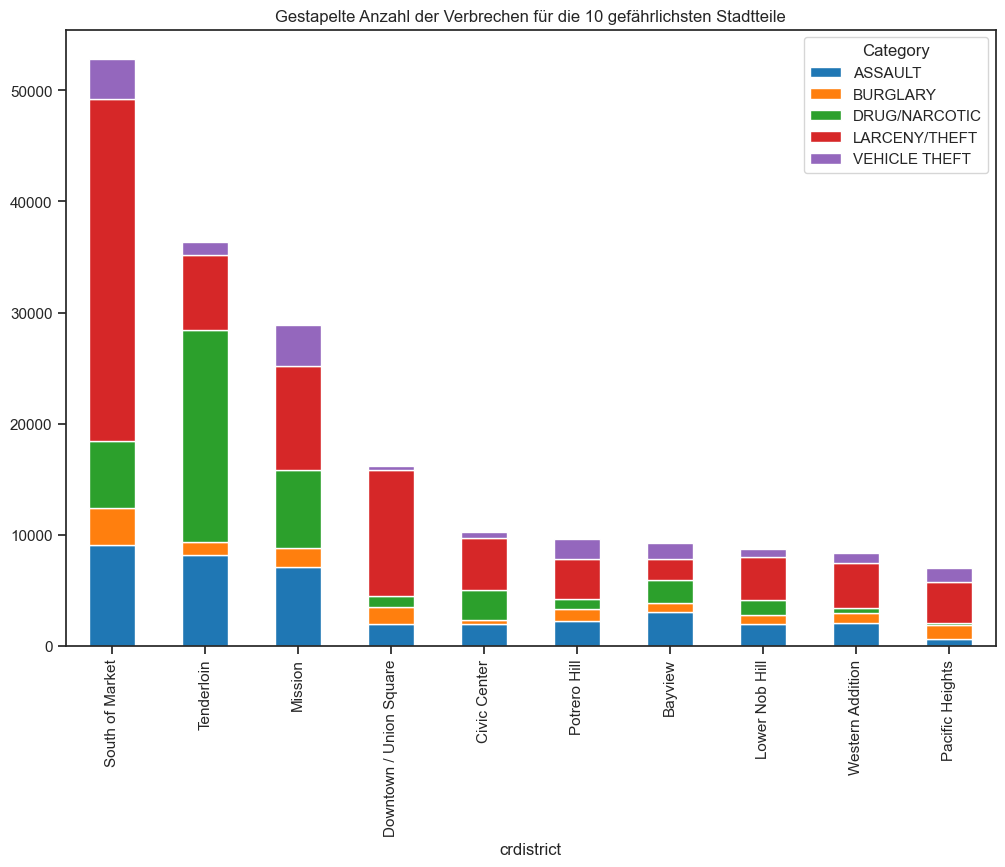

In [179]:

crdistrict_ct = pd.crosstab(crime["crdistrict"], crime["Category"], margins=True, margins_name="Total")

crdistrict_ct = crdistrict_ct[crdistrict_ct.index != "Total"]
crdistrict_ct = crdistrict_ct.sort_values(by="Total", ascending=False).head(10)
crdistrict_ct.drop('Total', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Gestapelte Anzahl der Verbrechen für die 10 gefährlichsten Stadtteile")
plt.show()

### Straßen

Außerdem werden Straßen dem Datensatz hinzugefügt. Ziel ist es, eine Übersicht der *gefährlichsten* Straßen in San Francisco zu bekommen.
Dazu wird die Adressen-Spalte mit Textoperationen zerteilt und die Straße von der Adresse abgetrennt. Die Straßen werden in *Street_1* gespeichert. Sollte es ein Häuserblock sein, steht die zweite Straße in *Street_2* 

In [182]:
is_block = crime["Address"].str.contains(" /")
crime.loc[is_block, "Street/Block"] = crime.loc[is_block, "Address"].copy()
crime.loc[is_block, "Street_1"] = crime.loc[is_block, "Address"].apply(lambda x: x.split(" /")[0]).copy()
crime.loc[is_block, "Street_2"] = crime.loc[is_block, "Address"].apply(lambda x: x.split(" /")[1]).copy()

is_street = crime["Address"].str.contains(" of ")
crime.loc[is_street, "Street/Block"] = crime.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()
crime.loc[is_street, "Street_1"] = crime.loc[is_street, "Address"].apply(lambda x: x.split(" of ")[1]).copy()
crime.loc[is_street, "Street_2"] = None
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CrimeId_,...,snow,wdir,wspd,wpgt,pres,tsun,coco,Street/Block,Street_1,Street_2
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,3,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,LOMBARD ST,LOMBARD ST,None
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,4,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,BRODERICK ST,BRODERICK ST,None
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,5,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,TEDDY AV,TEDDY AV,None
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,6,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,AVALON AV / PERU AV,AVALON AV,PERU AV
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,7,...,NaN,270.0,18.4,NaN,1014.0,NaN,NaN,KIRKWOOD AV / DONAHUE ST,KIRKWOOD AV,DONAHUE ST


In [183]:
str_cat_ct = pd.crosstab(crime["Street/Block"], crime["Category"], margins=True, margins_name="Total")

str_cat_ct = str_cat_ct[str_cat_ct.index != "Total"]
top_ten_str = str_cat_ct.sort_values(by="Total", ascending=False).head(10)
top_ten_str

Category,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,VEHICLE THEFT,Total
Street/Block,,,,,,
MARKET ST,2192,1254,2270,7675,197,13588
MISSION ST,2934,857,3063,3874,493,11221
BRYANT ST,2087,557,822,6737,317,10520
TURK ST,1181,266,2428,660,154,4689
OFARRELL ST,821,499,725,2387,250,4682
ELLIS ST,1028,233,1909,737,143,4050
EDDY ST,1380,329,1018,803,142,3672
POST ST,408,419,216,1796,162,3001
POWELL ST,470,264,114,2078,61,2987


Anhand der oberen Tabelle wird deutlich, dass es sich bei den drei gefährlichsten Straßen um die Market St, Mission St und Bryant St handelt. Hierbei ist jedoch die Länge der Straße zu beachten, damit diese Werte in ein geeignetes Verhältnis gesetzt werden können. Einige Straßen reichen durch nahezu die komplette Stadt, während andere kurz bemessen sind.

Analog zu den 10 gefährlichsten Stadtteilen folgt ein Balkendiagramm mit den 10 gefährlichsten Straßen.

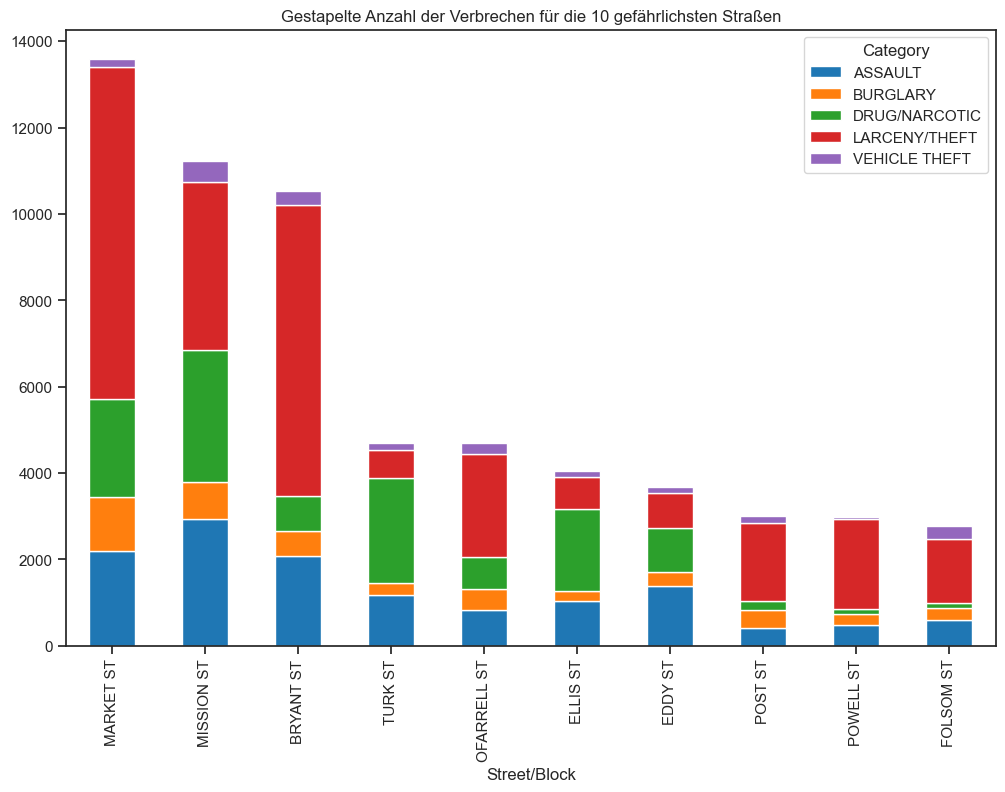

In [184]:
top_ten_str.drop('Total', axis=1).plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Gestapelte Anzahl der Verbrechen für die 10 gefährlichsten Straßen")
plt.show()

### Korrelationen

Nachfolgend werden weitere Korrelationen berechnet und visualisiert, um erneut Muster und Zusammenhänge in den Daten zu erkennen.


#### Korrelation zwischen Kategorien und Bezirken

Dafür wird im ersten Schritt eine Kreuztabelle für den Bezirk und die Kategorie erstellt.

In [185]:
df_district_cat = pd.crosstab(crime['Category'], crime['PdDistrict'])
df_district_cat.head()

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,9857,6977,8533,11149,8318,3515,3202,12183,5463,7679
BURGLARY,3930,4519,3331,3745,5854,2888,2696,4841,3463,1488
DRUG/NARCOTIC,4498,1805,2373,8757,4511,2573,999,9228,1531,17696
LARCENY/THEFT,10119,25060,10236,18223,28630,9146,9893,41845,11845,9903
VEHICLE THEFT,7219,4210,8960,7148,6291,3963,4117,4725,6142,1006


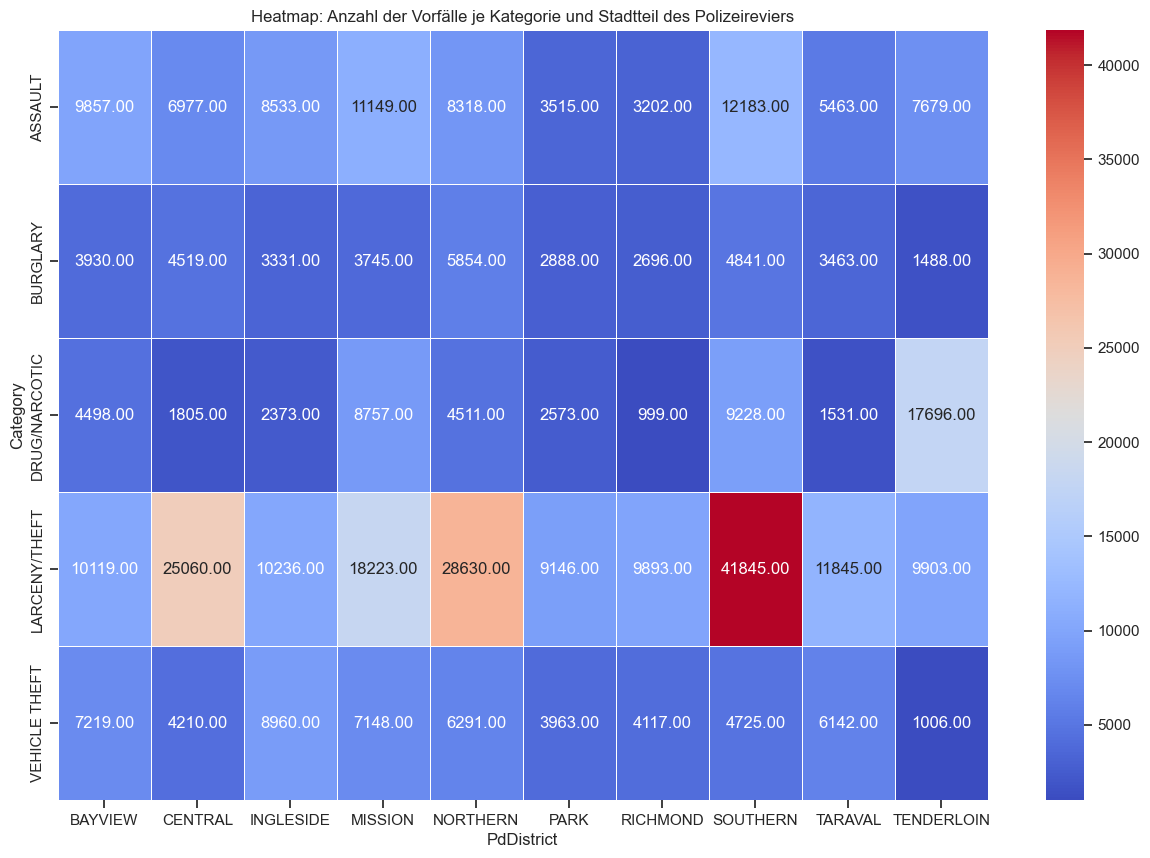

In [186]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_district_cat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap: Anzahl der Vorfälle je Kategorie und Stadtteil des Polizeireviers')
plt.show()

Anhand dieser Heat-Map wird ersichtlich, dass es besonders im Bezirk *Southern* ein hohes Aufkommen von *Larceny/Theft*-Kriminalfällen gab.

#### Korrelation zwischen den kategorischen Spalten

Um Eingrenzungen für Modellierung zu treffen, wird die Korrelation zwischen den kategorischen Spalten betrachtet.
Es werden nur Spalten berücksichtigt, die maximal 2500 Ausprägungen haben.


Dies sind die entsprechenden Spalten:

In [192]:
unique_val_col = pd.DataFrame(crime.nunique())
corr_columns = list(unique_val_col.loc[(unique_val_col[0] > 0) & (unique_val_col[0] <= 2500)].index)
print(corr_columns)

['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'YearMonth', 'YearMonthDay', 'MonthDay', 'Year', 'Month', 'Day', 'TimeOfDay', 'crdistrict', 'Holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'Street_1', 'Street_2']


In [40]:

x = [i[0] for i in product(corr_columns, corr_columns)]
y = [i[1] for i in product(corr_columns, corr_columns)]


corr_df = pd.DataFrame(index=corr_columns, columns=corr_columns)

for i in range(0,len(x)):
    if x[i] == y[i]:
        corr_df.loc[x[i], y[i]] = 1
        corr_df.loc[y[i], x[i]] = 1
    if pd.isnull(corr_df.loc[x[i], y[i]]):
        temp_ct = pd.crosstab(crime[x[i]], crime[y[i]])

        X2 = stats.chi2_contingency (temp_ct, correction= False )[0]
        n = sum(temp_ct.sum())
        minDim = min( temp_ct.shape )-1

        V = np.sqrt((X2/n) / minDim)

        corr_df.loc[x[i], y[i]] = V
        corr_df.loc[y[i], x[i]] = corr_df.loc[x[i], y[i]]

Zur Ermittlung der Korrelation wird Cramers-V genutzt. In einer Schleife wird der Chi-Quadrat Wert für alle Kombinationen aus den Spalten berechnet. 

Vgl. Cramér, H. (1946). Mathematical Methods of Statistics. Princeton: Princeton University Press, p. 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6.

Die Ergebnisse werden in einer Korrelationsmatrix dargestellt, wobei die doppelten Werte, auf der anderen Seite der Diagonalen zur besseren Übersichtlichkeit ausgeblendet werden.

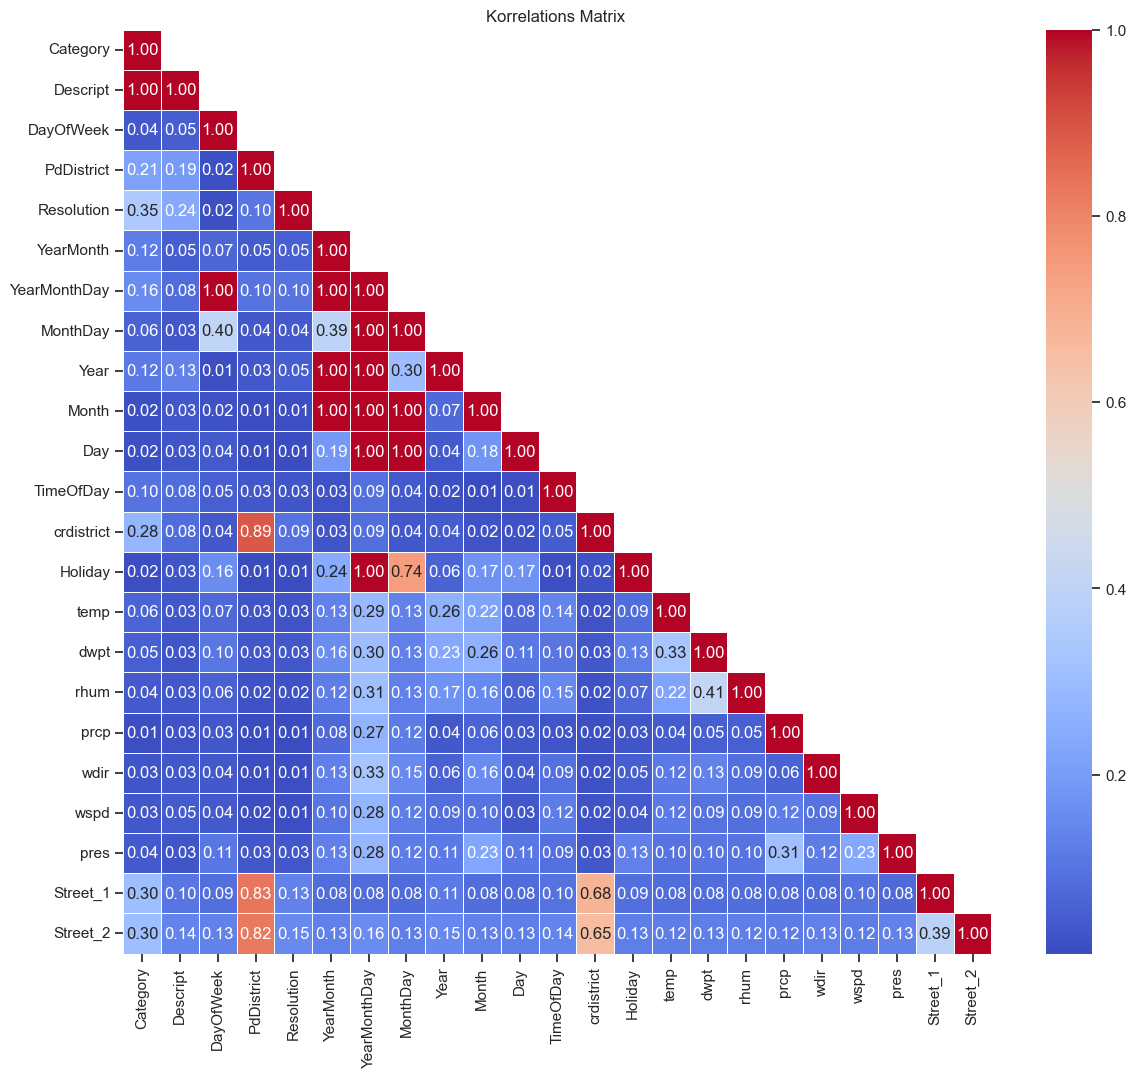

In [193]:
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations-Matrix ')
plt.show()

Anhand der Korrelationsmatrix können verschiedene Trends abgelesen werden. Dies wird die Entscheidungsgrundlage für die weitere Bearbeitung der Daten sein. Für die Betrachtung der Daten werden im Folgenden nur Features ausgewählt, die eine Korrelation größer/gleich 0.09 mit Category vorweisen können.

Die eingeschränkte Matrix sieht wie folgt aus:

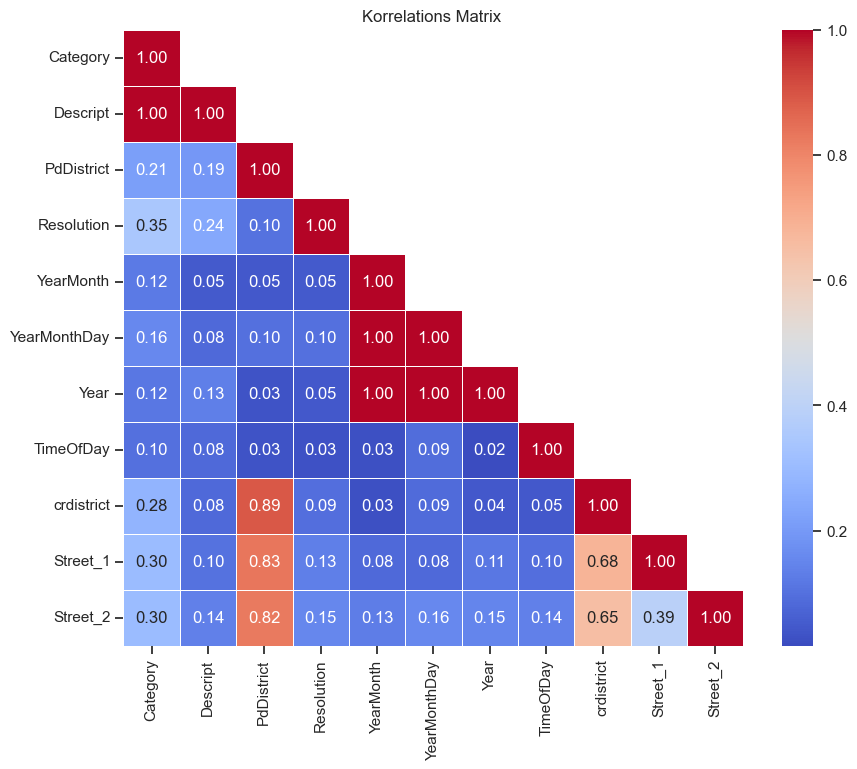

In [194]:
__corr_df = corr_df.loc[corr_df["Category"] >= 0.09]
#__corr_df = __corr_df.drop(["YearMonth", "Year", "Street_2"])
__corr_df = __corr_df.apply(pd.to_numeric, errors='coerce')
__corr_df = __corr_df[__corr_df.index]

mask = np.zeros_like(__corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(__corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Korrelations Matrix ')
plt.show()

Durch die Farben und die annotierten Werte können leicht Muster und Stärke der Korrelationen zwischen den verschiedenen Variablen im Datensatz erkannt werden. Besonders auffällig sind die vergleichsweise starken Korrelationen vom Verbrechensbezirk und den hinzugefügten Features Street_1 und Street_2. Die Resolution zeigt die größte Korrelation mit Category auf. Da die Resolution jedoch im Prinzip das Ergebnis "vorhersagt" wird dieses Feature nicht näher betrachtet. Das Ziel ist eine Vorhersage ohne die Berücksichtigung der Resolution. 

# 6. Vorbereitung

Anhand der Korrelation können wir ablesen, welche Spalten den größten Einfluss auf die Kategorie haben, welche wir letztendlich vorhersagen wollen.
Die Tabelle unten zeigt die konkreten Werte:

In [196]:
__corr_df["Category"]


Category        1.000000
Descript        1.000000
PdDistrict      0.213993
Resolution      0.346091
YearMonth       0.123561
YearMonthDay    0.158514
Year            0.115952
TimeOfDay       0.099248
crdistrict      0.277120
Street_1        0.302480
Street_2        0.302578
Name: Category, dtype: float64

Nun lässt sich entscheiden, welche Spalten für die Modellierung verwendet werden sollen. 


Dafür gibt es folgende Überlegungen: 

Descript hat eine sehr hohe Korrelation, aber enthält bereits Informationen zur Kategorie und ist deshalb nicht zielführend für die Modellierung. Ähnlich verhält es sich mit der Resolution, wie oben beschrieben. 
Die Spalten YearMonth, YearMonthDay und Year haben zwar eine größere Korrelation als TimeOfDay, aber sie werden trotzdem nicht in der Modellierung berücksichtigt, denn die Modelle sollen in der Lage sein, mit Daten aus der Zukunft zu arbeiten, und dafür ist ein Training mit Jahren aus der Vergangenheit nicht zielführend.

In [197]:
onehot_cols = __corr_df.index


#Obwohl Resolution für die Kaggle-Challange nicht verwendet werden darf, darf es im Rahmen des Projekts zur Klassifikation dienen.
#onehot_cols.remove("Resolution")


onehot_cols = onehot_cols.drop(["Resolution", "Category", "Descript", "YearMonth", 'YearMonthDay', "Year", "Street_2"])
list(onehot_cols)

['PdDistrict', 'TimeOfDay', 'crdistrict', 'Street_1']

Dadurch entstand die finale Liste mit den ausgewählten Features. Diese werden zunächst dem One-Hot-Encoding unterzogen, um die kategorialen Variablen in einem numerischen Format darzustellen, damit diese zu einem späteren Zeitpunkt von den Modellen verarbeitet werden können. Hierfür wird die Funktion pd.get_dummies() aus der Pandas-Bibliothek genutzt.  

In [45]:
# crime_bak = crime.copy()
# crime = crime_bak

In [46]:
# crime = crime.sample(frac=0.05)
# crime["Category"].unique()

## One-Hot-Encoding

Die sogenannten *Dummies* sind das Resultat der One-Hot-Kodierung

In [47]:
crime_dummies = pd.get_dummies(
    data=crime, 
    columns=onehot_cols, 
    dtype=float, 
    prefix=["_" + i for i in onehot_cols])
crime_dummies = crime_dummies.drop(["CrimeId_", "Street_2"], axis=1)
crime_dummies["Category"] = crime["Category"]
crime_dummies.head()

,Dates,Category,Descript,DayOfWeek,Resolution,Address,X,Y,YearMonth,YearMonthDay,...,_Street_1_YORBA ST,_Street_1_YORK ST,_Street_1_YOSEMITE AV,_Street_1_YOUNG CT,_Street_1_YUKON ST,_Street_1_ZAMPA LN,_Street_1_ZENO PL,_Street_1_ZIRCON PL,_Street_1_ZOE ST,_Street_1_ZOO RD
0,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,NONE,0 Block of TEDDY AV,-122.403252,37.713431,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,AVALON AV / PERU AV,-122.423327,37.725138,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,2015-05,2015-05-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Die One-Hot-kodierte Tabelle hat letztendlich 2141 Spalten.

In [200]:
crime_dummies.shape

(396283, 2141)

## Daten Angleichen

Wie in der deskriptiven Analyse erkennbar war, sind die Kategorien nicht gleichmäßig verteilt, was letztendlich zu einem Bias im Modell führt. 

Um dieser Entwicklung entgegenzuwirken, wurden die Daten mit SMOTE angepasst. Die Implementierung erfolgt durch das imbalanced-learn-Paket. Bei SMOTE handelt es sich um eine Methode zur Behandlung von Ungleichgewichten in Datensätzen. Es werden synthetische Beispiele für die unterrepräsentierte Klasse generiert, um das Gleichgewicht zwischen den Klassen zu verbessern. Das Ziel ist es, das Modell mit ausreichend Daten der unterrepräsentierten Klasse zu versorgen, um die Leistungsfähigkeit und Generalisierungsfähigkeit des Modells zu verbessern.

Hierfür wurde SMOTE in Kombination mit Undersampling verwendet. Die Daten werden erst auf Basis der vorhandenen Daten hochskaliert, um im Anschluss zufällige Werte zu löschen, damit eine Anpassung erfolgen kann.
Den Entwickler*innen von SMOTE zufolge, liefert eine Kombination beider Methoden bessere Ergebnisse als reines Undersampling.(Vgl. Chawla, N. V., Bowyer, K. W., Hall, L. O. & Kegelmeyer, W. P. (2002)

Beim Undersampling in diesem Fall wurden die Daten auf 70% reduziert. In einer Pipeline werden beide Methoden nacheinander aufgerufen.

In [48]:
X, y = crime_dummies.filter(like='_', axis=1), crime_dummies["Category"]
print("Dimensionen vor Angleichung",X.shape)
class_size = round(X.shape[0] / 5 * 0.7)

oversampling = SMOTE()
undersampling = RandomUnderSampler(sampling_strategy={i: class_size for i in categories})
steps = [('SMOTE', oversampling), ('RandomUnderSampler', undersampling)]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)
X_,y_ = X.copy(), y.copy()
print("Dimensionen nach Angleichung",X.shape)

Dimensionen vor Angleichung (396283, 2112)
Dimensionen nach Angleichung (277400, 2112)


Letztendlich ist eine Tabelle entstanden mit 277.400 Zeilen und 2.112 Spalten, welche zum Training an die Modelle übergeben wird.

# 7. Modellierung

Dieser Abschnitt wird sich auf die Modellierung konzentrieren – einen entscheidenden Schritt im maschinellen Lernprozess. Dabei werden algorithmische Modelle trainiert, um aus den bearbeiteten Daten Muster zu erlernen und Vorhersagen zu treffen. Zwei leistungsstarke und vielseitige Algorithmen, die in diesem Kontext verwendet werden, sind der Entscheidungsbaum und die Support Vector Machines (SVM).

## Entscheidungsbaum

Der Entscheidungsbaum ist ein Modellierungswerkzeug im Bereich des maschinellen Lernens, das in verschiedenen Disziplinen, von der Datenanalyse bis zur künstlichen Intelligenz, Anwendung findet. Es wird die Entscheidungsstruktur in Form eines Baumartigen Diagramms dargestellt. Hierbei stellen alle Knoten eine Entscheidung oder einen Test dar, wobei die nachfolgenden Zweige die möglichen Ergebnisse der Entscheidung aufzeigen. Entscheidungsbäume können insbesondere bei Klassifikationsproblemen eingesetzt werden und ermöglichen eine Interpretation und Vorhersage von Ergebnissen. Im weiteren Verlauf wird der Entscheidungsbaum Stück für Stück aufgebaut und optimiert.

### Daten Filtern

Da nach der One-Hot-Kodierung sehr viele Spalten entstanden sind, ist es sinnvoll die Anzahl zu reduzieren um das Training der Modelle zu optimieren.
Mit Hilfe des ChiQuadrat Tests können die relevantesten Spalten für den Entscheidungsbaum ermittelt werden. Die Funktion *SelectKBest* nutzt den Test um die besten Features zu ermitteln.

In [246]:
feature_selector = SelectKBest(chi2, k=100).fit(X, y)
X_new = X.iloc[:,feature_selector.get_support(indices=True)]

Im Folgenden werden zwei Entscheidungsbäume miteinander verglichen, jeweils mit den 100 besten Spalten als Resultat des Chi-Quadrat-Tests und allen Spalten. Damit die Ergebnisse reproduzierbar sind, wird dem Baum ein Random-Seed übergeben. 

Als Evaluierung dient eine 5-fache Kreuzvalidierung. Der Score, der zurückgegeben wird, gibt die Accuracy also die Genauigkeit des Modells an. Am Ende der Modellierung werden auch andere Werte betrachtet wie beispielsweise der F1-Wert.

Kreuzvalidierung eines einfachen Entscheidungsbaumes mit den 100 besten Spalten.

In [278]:
cross_validate(DecisionTreeClassifier(random_state=456), X_new, y, cv=5)["test_score"]

array([0.42880317, 0.42348594, 0.4250721 , 0.42536049, 0.42727109])

Kreuzvalidierung eines einfachen Entscheidungsbaumes mit allen Spalten

In [279]:
cross_validate(DecisionTreeClassifier(random_state=456), X, y, cv=5)["test_score"]

array([0.51937635, 0.5158075 , 0.51993511, 0.51690699, 0.51851118])

Die Qualität des Modells ändert sich bei Berücksichtigung aller Features verglichen mit 100 Features nur minimal, deshalb wird im nächsten Schritt ermittelt, welche Anzahl für einen Entscheidungsbaum am besten ist.

Dafür wird in einer Schleife mit jeder Iteration die Anzahl der Features jeweils um ein Zehntel der Gesamtanzahl erhöht bis 90% der Spaltenzahl erreicht ist.  

In [307]:
# decision_tree = DecisionTreeClassifier(
#     criterion         = 'entropy',
#     max_depth         = 16,
#     max_leaf_nodes    = 80,
#     min_samples_leaf  = 1,
#     min_samples_split = 500
# )

decision_tree = DecisionTreeClassifier(random_state=456)

scores = []
for k in range(round(X.shape[1]/10), round(X.shape[1]*0.9), round(X.shape[1]/10)):
    feature_selector = SelectKBest(chi2, k=k).fit(X, y)
    X_temp = X.iloc[:,feature_selector.get_support(indices=True)]
    cv_results = cross_validate(decision_tree, X_temp, y, cv=5)
    print("k\t\t=\t",k)
    print("score\t=\t",cv_results['test_score'].mean())
    print("-------------------------------------------------")
    scores = np.append(scores, (k, cv_results['test_score'].mean()))
    

k		=	 211
score	=	 0.4670583994232156
-------------------------------------------------
k		=	 422
score	=	 0.4929884643114636
-------------------------------------------------
k		=	 633
score	=	 0.5043439077144918
-------------------------------------------------
k		=	 844
score	=	 0.5105407354001443
-------------------------------------------------
k		=	 1055
score	=	 0.5130749819754866
-------------------------------------------------
k		=	 1266
score	=	 0.514632299927902
-------------------------------------------------
k		=	 1477
score	=	 0.5158940158615717
-------------------------------------------------
k		=	 1688
score	=	 0.5168817591925018
-------------------------------------------------
k		=	 1899
score	=	 0.5178658976207642
-------------------------------------------------


Letztendlich wird der Score aus der Kreuzvalidierung bezogen auf die Spaltenanzahl *k* dargestellt.

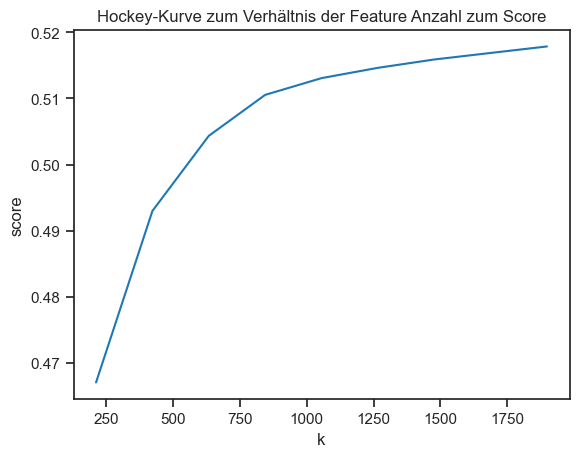

In [202]:
scores_df = pd.DataFrame.from_records([(scores[i],scores[i+1]) for i in range(0,len(scores),2)],  columns=["k", "score"])
sns.lineplot(scores_df, x="k", y="score")
plt.title("Hockey-Kurve zum Verhältnis der Feature Anzahl zum Score")
plt.show()

Wie das Diagramm zeigt, ändert sich die Qualität des Modells nur minimal ab einer Spaltenanzahl von 844.

Eine Wiederholung des Vorgangs in kleineren Schritten war geplant, aber lohnt sicht nicht, da keine großen Sprünge im Score erwartet werden können.

In [253]:
# decision_tree = DecisionTreeClassifier()
# 
# scores = []
# for k in range(750,1250,50):
#     feature_selector = SelectKBest(chi2, k=k).fit(X, y)
#     X_temp = X.iloc[:,feature_selector.get_support(indices=True)]
#     cv_results = cross_validate(decision_tree, X_temp, y, cv=5)
#     print("k\t\t=\t",k)
#     print("score\t=\t",cv_results['test_score'].mean())
#     print("-------------------------------------------------")
#     scores = np.append(scores, (k, cv_results['test_score'].mean()))

In [254]:
# scores_df_2 = pd.DataFrame.from_records([(scores[i],scores[i+1]) for i in range(0,len(scores),2)],  columns=["k", "score"])
# sns.lineplot(scores_df_2, x="k", y="score")

Nun kann die Spaltenanzahl für den Entscheidungsbaum eingegrenzt werden, dafür wird ein letztes Mal *SelectKBest* verwendet mit dem ermittelten Wert für *k*.

In [84]:
feature_selector = SelectKBest(chi2, k=844).fit(X, y)
X = X.iloc[:,feature_selector.get_support(indices=True)]
X.shape

(277400, 844)

### Feature Importance

Für den Entscheidungsbaum lässt sich die Feature-Importance ermitteln, sie gibt an, welche Spalten bzw. Features den größten Einfluss auf die Struktur des Baumes haben.

In [86]:
decision_tree = DecisionTreeClassifier(random_state=456)
decision_tree.fit(X,y)

feature_importance = decision_tree.feature_importances_

feature_importance_df = pd.DataFrame(X.columns, columns=["feature"])
feature_importance_df["importance"] = feature_importance
feature_importance_df.sort_values(by="importance", inplace=True, ascending=False)
feature_importance_df



,feature,importance
139,_crdistrict_Tenderloin,0.076493
28,_TimeOfDay_18,0.017292
27,_TimeOfDay_17,0.016675
26,_TimeOfDay_16,0.015890
25,_TimeOfDay_15,0.015866
...,...,...
396,_Street_1_EL CAMINO DEL MAR,0.000028
709,_Street_1_RUTH ST,0.000016
674,_Street_1_PIOCHE ST,0.000011
289,_Street_1_BRETHARTE TR,0.000003


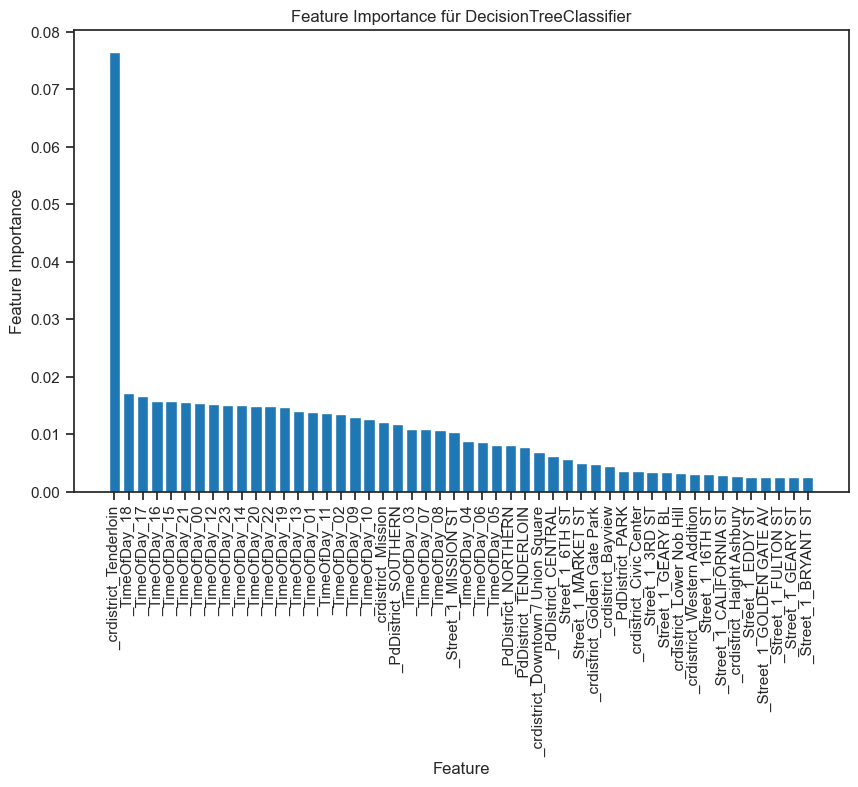

In [87]:
plt.figure(figsize=(10, 6))
plt.bar(range(0,50,1), feature_importance_df["importance"][0:50])
plt.xticks(range(0,50,1), feature_importance_df["feature"][0:50], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Feature Importance für DecisionTreeClassifier")
plt.show()

Obwohl die meisten Features zueinander einen ähnlichen Abstand haben, bezogen auf ihre Feature-Importance, gibt es einen Ausreißer: *_crdistrict_Tenderloin* hat die höchste Importance mit einem Wert von 0,076.
Es besagt, ob sich das jeweilige Verbrechen in Tenderloin zugetragen hat. Tenderloin ist dafür bekannt eines der gefährlichsten Bezirke zu sein, was auch in der deskriptiven Analyse erkennbar war.

### Hyperparameter Tuning

Im Rahmen des Hyperparameter Tunings gilt es die besten Parameter zu finden, dazu werden zwei Werkzeuge benutzt: *RandomizedSearchCV* und *GridSearchCV*.
Beide Methoden verwenden Kreuzvalidierung und generieren Scores für Modelle mit verschiedenen Parametern.

#### RandomizedSearchCV

RandomizedSearchCV ist eine Funktion aus dem scikit-learn-Paket in Python, die als Teil der Modellselektion und -abstimmung verwendet wird. Diese Funktion ermöglicht eine effiziente Suche über verschiedene Hyperparameter-Kombinationen für einen Machine-Learning-Algorithmus. Insbesondere wird RandomizedSearchCV für die Hyperparameter-Optimierung in Verbindung mit Kreuzvalidierung verwendet. (Vgl. RandomizedSearchCV. (s.d.). Scikit-learn Documentation)

Aus einem vorher definierten Parameter-Bereich für das Modell werden 50 zufällige Konfigurationen ausgewählt und es werden Bäume mit den jeweiligen Parametern generiert.

criterion: Die Funktion zur Messung der Qualität einer Aufteilung. Kann *gini* oder *entropy* sein.


max_depth: Die maximale Tiefe des Entscheidungsbaums. Kann eine ganze Zahl oder None für keine Begrenzung sein.


min_samples_split: Die minimale Anzahl von Beispielen, die erforderlich sind, um einen Knoten zu teilen.


min_samples_leaf: Die minimale Anzahl von Beispielen, die erforderlich sind, um ein Blatt zu bilden.


max_features: Die maximale Anzahl von Merkmalen, die für die Aufteilung eines Knotens in Betracht gezogen werden sollen.


splitter: Die Strategie zur Auswahl der Aufteilung an jedem Knoten, entweder *best* (beste Aufteilung) oder *random* (zufällige Aufteilung).







In der Ausgabe unten ist erkennbar, welche Parameter für den als letztes ausgeführten Baum verwendet wurden und wie lange die Laufzeit dauerte. 

In [315]:
from sklearn.model_selection import RandomizedSearchCV

decision_tree = DecisionTreeClassifier(random_state=456)

param_rand = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1,50,1),
    'min_samples_split': range(1,50,1),
    'min_samples_leaf': range(1,50,1),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'splitter': ['best', 'random']
}



random_search_cv = RandomizedSearchCV(
decision_tree, 
    param_distributions=param_rand, 
    n_iter=50, 
    verbose=2
    
)

random_search_cv = random_search_cv.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=33, splitter=random; total time=   1.3s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=33, splitter=random; total time=   1.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=33, splitter=random; total time=   1.1s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=33, splitter=random; total time=   1.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=33, splitter=random; total time=   1.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=46, min_samples_split=6, splitter=best; total time=   0.9s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=46, min_samples_split=6, splitter=best; 

Als Resultat wird eine Tabelle geliefert, mit Informationen zu den einzelnen probierten Parametern und den Scores der jeweiligen Kreuzvalidierung.

In [204]:
# Lokale Kopie der Ergebnisse
# random_search_results = pd.read_csv("data/random_search_tree.csv")

random_search_results = pd.DataFrame(random_search_cv.cv_results_)

params_column = random_search_results["params"]
params_df = params_column.apply(lambda x: pd.Series(eval(str(x))))
random_search_results = pd.concat([random_search_results, params_df], axis=1)
random_search_results = random_search_results.drop(["params"], axis=1)

random_search_results.to_csv("data/random_search_tree.csv")
random_search_results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,split4_test_score,mean_test_score,std_test_score,rank_test_score,splitter,min_samples_split,min_samples_leaf,max_features,max_depth,criterion
0,0,1.093297,0.125759,0.109367,0.003074,random,33,18,log2,20,...,0.280984,0.281190,0.004855,34,random,33,18,log2,20,gini
1,1,1.026752,0.101007,0.159331,0.067192,best,6,46,sqrt,3,...,0.215483,0.216247,0.001326,48,best,6,46,sqrt,3,entropy
2,2,1.678328,0.178575,0.109701,0.001442,random,30,35,auto,46,...,0.361734,0.369726,0.005623,11,random,30,35,auto,46,entropy
3,3,1.068732,0.027978,0.106086,0.001004,random,49,28,log2,45,...,0.313987,0.315869,0.008797,26,random,49,28,log2,45,gini
4,4,8.544053,0.274876,0.108766,0.001630,random,19,7,NaN,24,...,0.427794,0.429203,0.003404,5,random,19,7,NaN,24,gini
5,5,1.053644,0.136252,0.105013,0.002708,random,12,37,log2,16,...,0.241060,0.249470,0.007806,41,random,12,37,log2,16,entropy
6,6,10.870797,0.315094,0.118339,0.008166,random,32,11,NaN,49,...,0.455191,0.454632,0.001449,1,random,32,11,NaN,49,entropy
7,7,6.633948,0.096139,0.109949,0.005878,best,32,9,NaN,16,...,0.407895,0.407534,0.002629,8,best,32,9,NaN,16,entropy
8,8,1.261469,0.013749,0.105433,0.000844,best,20,28,auto,20,...,0.295260,0.298691,0.011532,31,best,20,28,auto,20,gini
9,9,0.901534,0.012609,0.101940,0.002087,best,46,29,log2,5,...,0.214870,0.215332,0.000679,49,best,46,29,log2,5,entropy


In [205]:
rs_top_10 = random_search_results.loc[random_search_results["rank_test_score"] <=10]
rs_top_10 = rs_top_10.filter(like="param_").iloc[:,[1,2,4]].astype('int64').describe()
rs_top_10

,param_min_samples_split,param_min_samples_leaf,param_max_depth
count,10.000000,10.000000,10.000000
mean,29.400000,20.900000,31.600000
std,7.676805,15.198319,11.852801
min,19.000000,1.000000,16.000000
25%,21.750000,9.500000,23.250000
50%,31.500000,16.500000,29.000000
75%,35.000000,32.000000,41.500000
max,41.000000,46.000000,49.000000


Die besten Parameter und der beste Score können ausgegeben werden:

In [318]:
random_search_cv.best_params_

{'splitter': 'random',
 'min_samples_split': 32,
 'min_samples_leaf': 11,
 'max_features': None,
 'max_depth': 49,
 'criterion': 'entropy'}

In [319]:
random_search_cv.best_score_

0.45463229992790194

Es war geplant den RandomizedSearchCV zu benutzen, um Grenzen zu finden für den nachfolgenden GridSearchCV, dafür sollten die min- und max-Werte der 10 besten Parameter dienen. Allerdings ist der Score mit den besten gefundenen Parametern (0,45) deutlich schlechter als ein unoptimierter Baum (0,51) von zuvor, daher werden die Ergebnisse des RandomizedSearchCV nicht weiter betrachtet.

#### GridSearchCV

GridSearchCV ist eine Funktion aus dem scikit-learn-Paket in Python, die für die Durchführung einer vollständigen Suche über einen festgelegten Hyperparameter-Raum in Verbindung mit Kreuzvalidierung verwendet wird. (Vgl. GridSearchCV. (s.d.). Scikit-learn Documentation. ))

Von der Verhaltensweise agiert GridSearchCV vergleichbar zum RandomizedSearchCV, allerdings werden wirklich alle möglichen Parameterkombinationen ausgeschöpft.

In [320]:
from joblib import parallel_backend

#Parameter vererbt aus Random Search (nicht verwendet)

# param_grid = {
# "criterion": ['entropy', 'gini'],
# "min_samples_split" : range(int(rs_top_10.loc["min","param_min_samples_split"]),int(rs_top_10.loc["max","param_min_samples_split"]),100),
# "min_samples_leaf" : range(int(rs_top_10.loc["min","param_min_samples_leaf"]),int(rs_top_10.loc["max","param_min_samples_leaf"]),100),
# "max_leaf_nodes": range(int(rs_top_10.loc["min","param_max_leaf_nodes"]),int(rs_top_10.loc["max","param_max_leaf_nodes"]),5),
# "max_depth" : range(int(rs_top_10.loc["min","param_max_depth"]),int(rs_top_10.loc["max","param_max_depth"]),5)
# }

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'splitter': ['best', 'random']
}


with parallel_backend('threading', n_jobs=-1):
    grid_search_cv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=456), param_grid=param_grid, cv= 5,verbose=2, n_jobs=-1)
    grid_search_cv.fit(X, y)


Fitting 5 folds for each of 960 candidates, totalling 4800 fits
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=  36.7s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=  36.3s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=  36.7s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=  40.0s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=  40.1s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=  34.7s
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; tota

In [321]:
# grid_search_results = pd.read_csv("data/grid_search_tree.csv")
grid_search_results = pd.DataFrame(grid_search_cv.cv_results_)

params_column = grid_search_results["params"]
params_df = params_column.apply(lambda x: pd.Series(eval(str(x))))
grid_search_results = pd.concat([grid_search_results, params_df], axis=1)
grid_search_results = grid_search_results.drop(["params"], axis=1)
grid_search_results.to_csv("data/grid_search_tree.csv")
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,...,split4_test_score,mean_test_score,std_test_score,rank_test_score,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter
0,38.142799,0.631497,3.380108,1.584996,gini,None,auto,1,2,best,...,0.506345,0.505620,0.002286,14,gini,NaN,auto,1,2,best
1,43.752258,10.049867,7.950033,2.708375,gini,None,auto,1,2,random,...,0.500757,0.499921,0.001496,25,gini,NaN,auto,1,2,random
2,43.172251,12.227911,3.443242,1.166929,gini,None,auto,1,4,best,...,0.502055,0.502491,0.002667,21,gini,NaN,auto,1,4,best
3,33.173504,1.643699,3.422845,0.964773,gini,None,auto,1,4,random,...,0.497819,0.498115,0.001822,39,gini,NaN,auto,1,4,random
4,37.831465,10.608804,4.731255,0.596571,gini,None,auto,1,8,best,...,0.499531,0.499903,0.003116,27,gini,NaN,auto,1,8,best
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,46.529202,6.141684,3.576107,2.055568,entropy,40,None,8,2,random,...,0.454542,0.456410,0.002033,139,entropy,40.0,None,8,2,random
956,46.174719,4.487077,1.701546,1.248179,entropy,40,None,8,4,best,...,0.459229,0.459394,0.002065,124,entropy,40.0,None,8,4,best
957,41.291429,0.510933,1.153527,0.478880,entropy,40,None,8,4,random,...,0.454542,0.456410,0.002033,139,entropy,40.0,None,8,4,random
958,32.791099,1.836218,0.507933,0.126266,entropy,40,None,8,8,best,...,0.459229,0.459394,0.002065,124,entropy,40.0,None,8,8,best


Nach der abgeschlossenen Parametersuche, können die besten Parameter und die damit erzielte Accuracy ausgegeben werden.

In [322]:
print(grid_search_cv.best_params_,grid_search_cv.best_score_)

{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 0.5105407354001443


Nun kann der finale Baum mit den Parametern generiert werden.

In [336]:
decision_tree = DecisionTreeClassifier(
    criterion         = 'gini',
    max_depth         = None,
    max_features      = None,
    min_samples_leaf    = 1,
    min_samples_split  = 2,
    splitter = 'best',
    random_state=456
)

### Konfusionsmatrix

Um das Ergebnis des Entscheidungsbaumes zu unterstützen wird eine Konfusionsmatrix erstellt. Hiermit kann übersichtlich überprüft werden, wie viele Kriminalitätsfälle pro Kategorie richtig vorhergesagt wurden. Sie zeigt auch, wie sich Fehler des Modells äußern. 

Da für die Evaluierung bereits Kreuzvalidierung benutzt wurde, werden auch die Vorhersagen via Kreuzvalidierung ermittelt. Dazu dient die *cross_val_predict* Funktion.

In [337]:
y_pred = cross_val_predict(decision_tree, X, y, cv=5)

conf_matrix = confusion_matrix(y, y_pred, labels=categories)
conf_matrix

array([[25996, 10298,  6070,  6432,  6684],
       [ 9690, 23232, 11032,  5524,  6002],
       [ 5021,  6495, 38259,  2718,  2987],
       [ 9114,  8074,  4435, 26367,  7490],
       [ 9310,  7608,  4480,  6312, 27770]], dtype=int64)

Im nächsten Schritt wird die Matrix mit Seaborn übersichtlicher dargestellt. 

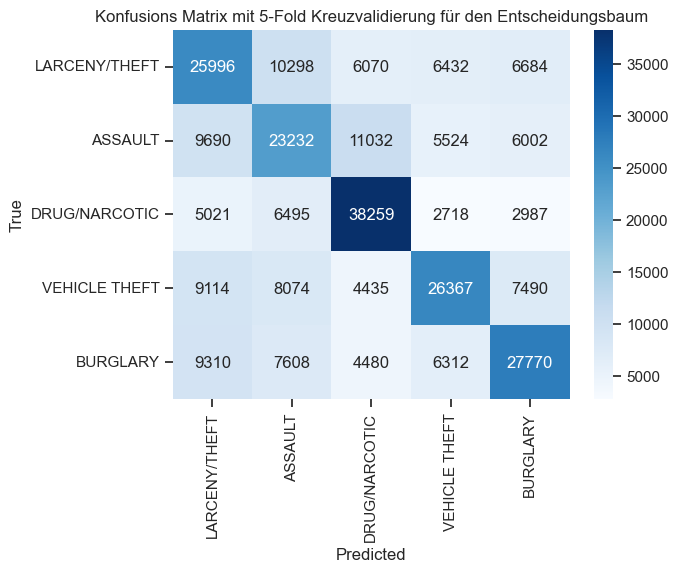

In [338]:
 #Konfusionsmatrix mit Seaborn dargestellt
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Konfusions Matrix mit 5-Fold Kreuzvalidierung für den Entscheidungsbaum')
plt.show()

Nach Betrachtung der Matrix wird deutlich, dass Drogenkriminalität am meisten richtig klassifiziert wurde, allerdings werden auch viele Gewaltstraftaten (ASSAULT) fälschlicherweise als DRUG/NARCOTIC klassifiziert. Dieses Verhalten des Modells spiegelt auch die zuvor betrachtet Feature-Importance wider, denn Tenderloin ist ein Stadtteil, in dem Drogenkriminalität besonders präsent ist. Es lässt sich vermuten, dass Vorfälle, die sich in Tenderloin abspielen, häufig als Drogendelikte gewertet werden. LARCENY/THEFT weist ebenfalls viele Klassifikationsfehler auf. 

### Classification Report

Zum Abschluss wird der Classification Report aus dem scikit-learn-Paket genutzt, um eine Zusammenfassung der wichtigsten Klassifikationsmetriken für die Bewertung der Leistung des Entscheidungsbaums zu liefern. Der Report nimmt die wahren Klassenetiketten und die vorhergesagten Klassenetiketten als Eingabe und gibt Präzision, Recall, F1-Score und andere Metriken für jede Klasse sowie den gewichteten Durchschnitt dieser Metriken aus.

In [339]:
report_tree = classification_report(y, y_pred)
print("Classification Report:\n", report_tree)


Classification Report:
                precision    recall  f1-score   support

      ASSAULT       0.42      0.42      0.42     55480
     BURGLARY       0.55      0.50      0.52     55480
DRUG/NARCOTIC       0.60      0.69      0.64     55480
LARCENY/THEFT       0.44      0.47      0.45     55480
VEHICLE THEFT       0.56      0.48      0.51     55480

     accuracy                           0.51    277400
    macro avg       0.51      0.51      0.51    277400
 weighted avg       0.51      0.51      0.51    277400


Wie zuvor bereits beobachtet, fungiert das Modell am besten in der Identifikation von Drogendelikten. Hier gibt es die höchsten Werte für alle Scores. 
Am schlechtesten verhält sich der Baum bei der Klassifikation von Gewaltstraftaten, 58% davon werden falsch klassifiziert.
Die allgemeine Vorhersagegenauigkeit von 51% (Accuracy) bedeutet , dass es sich generell um kein gutes Modell handelt. Wenn 49% aller Kategorien falsch zugeordnet werden, sollte man sich in der Verbrechensbekämpfung nicht auf dieses Modell verlassen. Es ist auch zu sehen, dass die Hyperparameteroptimierung zu keiner wirklichen Verbesserung des Modells geführt hat, denn eine ähnliche Accuracy wurde bereits ohne Anpassung der Parameter erzielt. 

## Support Vector Machines

Anders als beim Entscheidungsbaum wird an dieser Stelle auf ein Modell mit 100 Features in Gegenüberstellung zu allen Features verzichtet, da dies auch im nächsten Schritt deutlich wird.

### Daten Filtern

Bevor die optimale Spaltenanzahl ermittelt werden kann, wie beim Entscheidungsbaum, müssen wieder die ursprünglichen Dimensionen der Daten hergestellt werden. Dazu dient der Abruf der Werte X_ und y_, welche beim One-Hot-Encoding als Kopie dienten. 

In [53]:
# X und y werden wieder auf ihre ursprüngliche Größe gesetzt
X, y = X_, y_ 

Auch hier wird auf gleiche Art und Weise, wie beim Entscheidungsbaum die optimale Feature-Anzahl ermittelt.

In [309]:


svm = LinearSVC(random_state=456)

scores = []
for k in range(round(X.shape[1]/10), round(X.shape[1]*0.9), round(X.shape[1]/10)):
    feature_selector = SelectKBest(chi2, k=k).fit(X, y)
    X_temp = X.iloc[:,feature_selector.get_support(indices=True)]
    cv_results = cross_validate(svm, X_temp, y, cv=5)
    print("k\t\t=\t",k)
    print("score\t=\t",cv_results['test_score'].mean())
    print("-------------------------------------------------")
    scores = np.append(scores, (k, cv_results['test_score'].mean()))
    

k		=	 211
score	=	 0.41021629416005767
-------------------------------------------------
k		=	 422
score	=	 0.4218565248738284
-------------------------------------------------
k		=	 633
score	=	 0.4263554434030281
-------------------------------------------------
k		=	 844
score	=	 0.4292465753424658
-------------------------------------------------
k		=	 1055
score	=	 0.4311499639509734
-------------------------------------------------
k		=	 1266
score	=	 0.43242970439798123
-------------------------------------------------
k		=	 1477
score	=	 0.4334066330209084
-------------------------------------------------
k		=	 1688
score	=	 0.4335904830569574
-------------------------------------------------
k		=	 1899
score	=	 0.4332912761355443
-------------------------------------------------


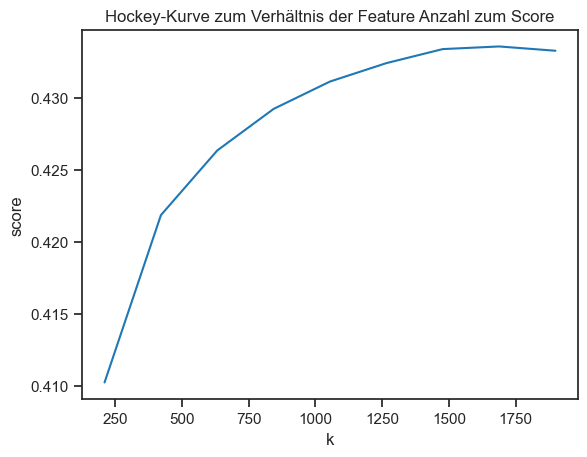

In [211]:
scores_df = pd.DataFrame.from_records([(scores[i],scores[i+1]) for i in range(0,len(scores),2)],  columns=["k", "score"])
sns.lineplot(scores_df, x="k", y="score")
plt.title("Hockey-Kurve zum Verhältnis der Feature Anzahl zum Score")
plt.show()

Wieder kann die Hockey-Kurve und die Ausgabe zur Identifizierung genutzt werden. In diesem Fall wurde sich für 1055 Spalten entschieden. Erstaunlicherweise liefert das Modell bei einer Feature-Anzahl größer als 1750 sogar schlechter werdende Ergebnisse.

Auf eine weitere Iteration des Prozesses wird verzichtet.

In [290]:
# svm = LinearSVC(random_state=456)
# 
# scores = []
# for k in range(200,450,50):
#     feature_selector = SelectKBest(chi2, k=k).fit(X, y)
#     X_temp = X.iloc[:,feature_selector.get_support(indices=True)]
#     cv_results = cross_validate(svm, X_temp, y, cv=5)
#     print("k\t\t=\t",k)
#     print("score\t=\t",cv_results['test_score'].mean())
#     print("-------------------------------------------------")
#     scores = np.append(scores, (k, cv_results['test_score'].mean()))

In [291]:
# scores_df_2 = pd.DataFrame.from_records([(scores[i],scores[i+1]) for i in range(0,len(scores),2)],  columns=["k", "score"])
# sns.lineplot(scores_df_2, x="k", y="score")

Final wird also die Spaltenanzahl reduziert und es kann mit der Hyperparameter Optimierung begonnen werden.

In [56]:
from sklearn.feature_selection import SelectKBest, chi2
feature_selector = SelectKBest(chi2, k=1055).fit(X, y)
X = X.iloc[:,feature_selector.get_support(indices=True)]

### Hyperparameter Tuning

Nun gilt es die besten Parameter zu finden, in diesem Fall wird auf RandomSearch verzichtet und lediglich GridSearch verwendet.

Folgende Parameter werden angepasst:

C: Der Strafterm für die Fehlerklassifikation. Kleinere Werte erlauben mehr Fehler in der Trainingsmenge, während größere Werte zu einer strengeren Klassifikation führen.

loss: Die Verlustfunktion, die minimiert werden soll. *Hinge* ist standardmäßig für lineare SVMs, während *squared_hinge* für quadratische Hinge-Verluste steht.

penalty: Die Strafart für die Regularisierung. *l1* steht für L1-Regularisierung (Lasso), *l2* für L2-Regularisierung (Ridge).

dual: Gibt an, ob die duale oder primale Form des Optimierungsproblems gelöst werden soll. True für duales Problem, False für primales Problem.

tol: Toleranzkriterium für die Beendigung des Optimierungsalgorithmus. Es definiert den Stoppkriteriumschwellenwert.

#### GridSearchCV

In [57]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'dual': [True, False],
    'tol': [1e-3, 1e-4, 1e-5]
}

with parallel_backend('threading', n_jobs=-1):
    grid_search_cv = GridSearchCV(estimator=LinearSVC(random_state=456), param_grid=param_grid, cv=5,verbose=2, n_jobs=-1)
    grid_search_cv.fit(X, y)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.001; total time=  25.9s[CV] END C=0.001, dual=True, loss=hinge, penalty=l1, tol=0.0001; total time=  24.7s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l1, tol=1e-05; total time=  42.4s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l1, tol=1e-05; total time=  52.3s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.0001; total time=  25.9s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.0001; total time=  30.1s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.0001; total time=  25.4s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.001; total time= 1.1min
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.0001; total time=  26.6s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=0.0001; total time=  24.2s
[CV] END C=0.001, dual=True, loss=hinge, penalty=l2, tol=1e-05; total time= 1.4min
[CV] END C=0.001, d

In [58]:
# grid_search_results = pd.read_csv("data/grid_search_svm.csv")
grid_search_results = pd.DataFrame(grid_search_cv.cv_results_)

params_column = grid_search_results["params"]
params_df = params_column.apply(lambda x: pd.Series(eval(str(x))))
grid_search_results = pd.concat([grid_search_results, params_df], axis=1)
grid_search_results = grid_search_results.drop(["params"], axis=1)
grid_search_results.to_csv("data/grid_search_svm.csv")
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_loss,param_penalty,param_tol,split0_test_score,...,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,C,dual,loss,penalty,tol
0,185.824994,0.688300,0.000000,0.000000,0.001,True,hinge,l1,0.001,NaN,...,NaN,NaN,NaN,NaN,72,0.001,True,hinge,l1,0.00100
1,153.450712,64.302729,0.000000,0.000000,0.001,True,hinge,l1,0.0001,NaN,...,NaN,NaN,NaN,NaN,72,0.001,True,hinge,l1,0.00010
2,131.452944,68.651652,0.000000,0.000000,0.001,True,hinge,l1,0.00001,NaN,...,NaN,NaN,NaN,NaN,72,0.001,True,hinge,l1,0.00001
3,131.439787,80.367136,12.064105,8.629014,0.001,True,hinge,l2,0.001,0.329776,...,0.322621,0.328785,NaN,NaN,72,0.001,True,hinge,l2,0.00100
4,25.242638,2.040275,1.277609,0.227219,0.001,True,hinge,l2,0.0001,0.315970,...,0.303064,0.304957,0.306543,0.005238,56,0.001,True,hinge,l2,0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,105.153909,16.446747,12.621798,6.256242,100,False,squared_hinge,l1,0.0001,0.431236,...,0.433111,0.429668,0.431438,0.001199,26,100.000,False,squared_hinge,l1,0.00010
140,90.442453,2.768328,16.604964,7.147565,100,False,squared_hinge,l1,0.00001,0.431291,...,0.433147,0.429650,0.431442,0.001214,25,100.000,False,squared_hinge,l1,0.00001
141,75.551063,5.507758,4.601747,4.905304,100,False,squared_hinge,l2,0.001,0.431669,...,0.433129,0.429668,0.431572,0.001179,9,100.000,False,squared_hinge,l2,0.00100
142,144.012219,10.174666,0.367158,0.022347,100,False,squared_hinge,l2,0.0001,0.431363,...,0.433165,0.429704,0.431474,0.001209,19,100.000,False,squared_hinge,l2,0.00010


In [59]:
print(grid_search_cv.best_params_,grid_search_cv.best_score_)

{'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.001} 0.4318060562364816


Ein kurzer Blick auf die Ergebnisse genügt, um zu sehen, dass die Support Vector Machines schlechter klassifizieren, als der Entscheidungsbaum. 

### Optimierte Support Vector Machine

Nun kann das finale Modell mit den Parametern generiert werden.

In [60]:
svm = LinearSVC(
    C = 0.1,
    loss = 'squared_hinge',
    penalty = 'l2',
    dual = False,
    tol = 0.001,
    random_state=456
)

## Konfusionsmatrix

Um das Ergebnis der Support Vector Machines zu unterstützen wird eine Konfusionsmatrix erstellt. Hiermit kann übersichtlich überprüft werden, wie viele Kriminalitätsfälle pro Kategorie richtig vorhergesagt wurden. 

In [62]:

y_pred = cross_val_predict(svm, X, y, cv=5)

conf_matrix = confusion_matrix(y, y_pred, labels=categories)
conf_matrix

array([[22773,  5656,  7192, 10268,  9591],
       [ 9934, 14703, 12993,  9993,  7857],
       [ 5748,  5858, 35882,  4770,  3222],
       [ 7378,  6281,  4827, 26884, 10110],
       [11434,  7097,  5086, 12322, 19541]], dtype=int64)

Im nächsten Schritt wird die Matrix mit Seaborn übersichtlicher dargestellt. 

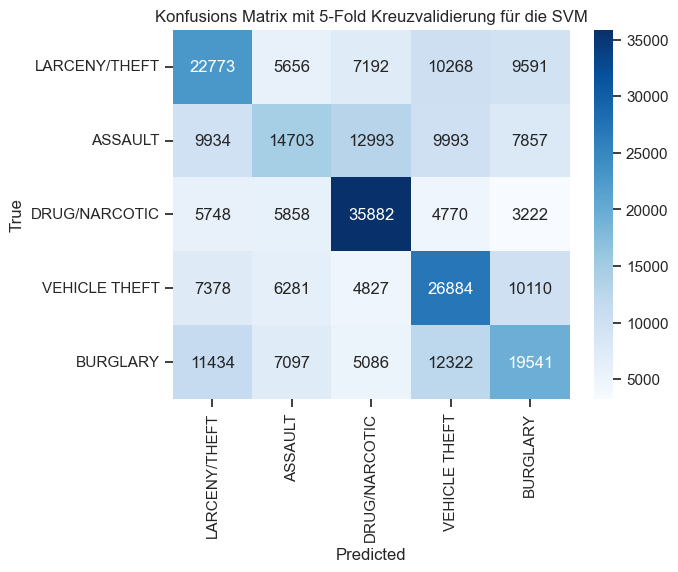

In [63]:
 #Konfusionsmatrix mit Seaborn dargestellt
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Konfusions Matrix mit 5-Fold Kreuzvalidierung für die SVM')
plt.show()

Ähnlich wie beim Entscheidungsbaum wurde Drogenkriminalität am meisten richtig klassifiziert. Bei SVM wird eine hohe Falschklassifikation von ASSAULT und BURGLARY deutlich. Auch hier werden wieder viele Gewaltstraftaten fälschlicherweise als DRUG/NARCOTIC klassifiziert, sogar noch mehr als beim Entscheidungsbaum. 



## Classification Report

Auch hier dient zur entgültigen Bewertung der Classification Report.

In [83]:
report_svm = classification_report(y, y_pred)
print("Classification Report:\n", report_svm)


Classification Report:
                precision    recall  f1-score   support

      ASSAULT       0.37      0.27      0.31     55480
     BURGLARY       0.39      0.35      0.37     55480
DRUG/NARCOTIC       0.54      0.65      0.59     55480
LARCENY/THEFT       0.40      0.41      0.40     55480
VEHICLE THEFT       0.42      0.48      0.45     55480

     accuracy                           0.43    277400
    macro avg       0.42      0.43      0.42    277400
 weighted avg       0.42      0.43      0.42    277400




Wie zuvor bereits beobachtet, fungiert das Modell am besten in der Identifikation von Drogendelikten. Hier gibt es die höchsten Werte für alle Scores. 
Am schlechtesten verhalten sich SVM bei der Klassifikation von Gewaltstraftaten, 63% davon werden falsch klassifiziert.
Die allgemeine Vorhersagegenauigkeit von 42% (Accuracy) bedeutet, dass es sich generell um kein gutes Modell handelt, denn 58% aller Kategorien werden falsch zugeordnet. Es ist auch hier zu sehen, dass die Hyperparameteroptimierung wie beim Baum zu keiner wirklichen Verbesserung des Modells geführt hat.

# 8. Fazit

Zwar liefert der Entscheidungsbaum bessere Ergebnisse mit einer Accuracy von 51% verglichen mit den 42% der SVM, aber keines der Modelle sollte für die Klassifikation verwendet werden. Je nach Anwendungsfall sollten Modelle mit einer Genauigkeit von mindestens 90% verwendet werden. 
Die verwendeten Features haben einen starken Fokus auf Geodaten, für zukünftige Modellierungen ist es sinnvoll andere Dimensionen zu betrachten oder gar neue Daten zu erheben, um einen Bias zu reduzieren. Auch wenn manche Straftaten in manchen Stadtteilen häufiger auftreten, sollte dies nicht alleinige Entscheidungsgrundlage sein. 
Die Wetterdaten, die betrachtet wurden haben keinen signifikanten Einfluss auf die Verbrechen aufweisen können.
In dieser Modellierung wurde sich bewusst auf Modelle aus der Vorlesung reduziert, da bei diesen Modellen die Funktionsweise nachvollziehbarer ist. In Zukunft können komplexere Modelle bessere Ergebnisse liefern, beispielsweise ist vermehrt XGBoost in der Recherche aufgetreten und wurde zum lösen des gleichen Klassifikationsproblems genutzt.
 Die Hyperparameter-Optimierung war enorm rechenaufwändig und mit normalen PCs kaum umsetzbar, da 32GB RAM benötigt wurden, hier wäre es besser gewesen auf dedizierte Data Mining Server zurückzugreifen.


# II. Quellen

- Pappas, Yannis. "SF Crime Analysis & Prediction." Kaggle, https://www.kaggle.com/code/yannisp/sf-crime-analysis-prediction.
- Chawla, N. V., Bowyer, K. W., Hall, L. O. & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling technique. Journal Of Artificial Intelligence Research, 16, 321–357. https://doi.org/10.1613/jair.953
- City and County of San Francisco. (2016). SF Find Neighborhoods. [Dataset]. Socrata. https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Cramér, H. (1946). Mathematical Methods of Statistics. Princeton: Princeton University Press, p. 282 (Chapter 21. The two-dimensional case). ISBN 0-691-08004-6.
- "RandomizedSearchCV. (s.d.). Scikit-learn Documentation." https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- "GridSearchCV. (s.d.). Scikit-learn Documentation." https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- "Jason Brownlee. SMOTE for Imbalanced Classification with Python" https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/